# Telecom Churn - Case Study

In [1]:
# Importing the required libraries and packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

from sklearn.metrics import confusion_matrix
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the dataset
telecom = pd.read_csv("telecom_churn_data.csv")
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
telecom.shape

(99999, 226)

In [4]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [5]:
telecom.isnull().sum()/len(telecom.index)

mobile_number     0.00000
circle_id         0.00000
loc_og_t2o_mou    0.01018
std_og_t2o_mou    0.01018
loc_ic_t2o_mou    0.01018
                   ...   
aon               0.00000
aug_vbc_3g        0.00000
jul_vbc_3g        0.00000
jun_vbc_3g        0.00000
sep_vbc_3g        0.00000
Length: 226, dtype: float64

In [6]:
round(100*(telecom.isnull().sum()/len(telecom.index)), 2)

mobile_number     0.00
circle_id         0.00
loc_og_t2o_mou    1.02
std_og_t2o_mou    1.02
loc_ic_t2o_mou    1.02
                  ... 
aon               0.00
aug_vbc_3g        0.00
jul_vbc_3g        0.00
jun_vbc_3g        0.00
sep_vbc_3g        0.00
Length: 226, dtype: float64

## Data Preparation

- Derive new features
- Filter high-value customers
- Tag churners and remove attributes of the churn phase

In [7]:
# Creating Churn Data
telecom_df = telecom

telecom_df['total_rech_amt_good_phase'] = (telecom_df['total_rech_amt_6'] + telecom_df['total_rech_amt_7'])/2

#filtering high value customers
telecom_df = telecom_df[telecom_df['total_rech_amt_good_phase'] > telecom_df['total_rech_amt_good_phase'].quantile(0.70)]

#The attributes needed to use to tag churners
telecom_df['total_usage'] = telecom_df['total_og_mou_9'] + telecom_df['total_ic_mou_9'] + telecom_df['vol_2g_mb_9'] + telecom_df['vol_3g_mb_9']

telecom_df['churn'] = np.where(telecom_df['total_usage']== 0, 1, 0)
telecom_df['churn'].value_counts()


0    27390
1     2589
Name: churn, dtype: int64

In [8]:
telecom_df = telecom_df.drop(['total_rech_amt_good_phase','total_usage'],1)

In [9]:
#Dropping the data of 9th month
month_nine = [col for col in telecom_df.columns if '_9' in col]

telecom_df = telecom_df.drop(month_nine, axis = 1)
telecom_df = telecom_df.drop('sep_vbc_3g', axis=1)

telecom_df.shape

(29979, 172)

In [10]:
# Calculating Churn Rate
churn_col = telecom_df['churn']
churn_rate = (sum(churn_col)/len(churn_col.index))*100
churn_rate

8.636045231662164

In [11]:
telecom_df.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,2.997900e+04,29979.0,29865.0,29865.0,29865.0,29979.000000,29979.000000,29979.000000,29663.000000,29676.000000,...,29979.000000,29979.000000,11387.000000,11652.000000,11741.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,7.001223e+09,109.0,0.0,0.0,0.0,587.587624,589.424681,535.067748,299.392147,307.701888,...,0.150339,0.140498,0.897603,0.889804,0.837322,1264.158911,129.482436,135.225368,121.450911,0.08636
std,6.846594e+05,0.0,0.0,0.0,0.0,442.848876,463.049067,492.447887,462.369385,483.432401,...,0.969779,0.975212,0.303184,0.313147,0.369087,975.181038,390.625027,408.218570,389.910814,0.28090
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.00000
25%,7.000641e+09,109.0,0.0,0.0,0.0,364.352500,365.235000,289.782000,43.030000,42.775000,...,0.000000,0.000000,1.000000,1.000000,1.000000,480.000000,0.000000,0.000000,0.000000,0.00000
50%,7.001232e+09,109.0,0.0,0.0,0.0,495.951000,493.781000,452.232000,128.480000,128.120000,...,0.000000,0.000000,1.000000,1.000000,1.000000,914.000000,0.000000,0.000000,0.000000,0.00000
75%,7.001814e+09,109.0,0.0,0.0,0.0,704.184500,700.986000,671.349500,357.655000,365.127500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1923.500000,1.600000,2.025000,0.000000,0.00000
max,7.002411e+09,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,35.000000,41.000000,1.000000,1.000000,1.000000,4321.000000,12916.220000,9165.600000,11166.210000,1.00000


In [12]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29979 entries, 7 to 99997
Columns: 172 entries, mobile_number to churn
dtypes: float64(135), int64(28), object(9)
memory usage: 39.6+ MB


In [13]:
#Dropping all columns with unique value
telecom_data_prep = telecom_df
telecom_data_prep = telecom_data_prep.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6',
                     'std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7',
                   'std_ic_t2o_mou_8','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], 1)
telecom_data_prep.describe()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,2.997900e+04,29979.000000,29979.000000,29979.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,...,29979.000000,29979.000000,11387.000000,11652.000000,11741.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,7.001223e+09,587.587624,589.424681,535.067748,299.392147,307.701888,276.459159,422.582059,428.433657,387.277278,...,0.150339,0.140498,0.897603,0.889804,0.837322,1264.158911,129.482436,135.225368,121.450911,0.08636
std,6.846594e+05,442.848876,463.049067,492.447887,462.369385,483.432401,471.700220,471.281393,487.288606,480.450594,...,0.969779,0.975212,0.303184,0.313147,0.369087,975.181038,390.625027,408.218570,389.910814,0.28090
min,7.000000e+09,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.00000
25%,7.000641e+09,364.352500,365.235000,289.782000,43.030000,42.775000,32.240000,141.440000,139.627500,107.680000,...,0.000000,0.000000,1.000000,1.000000,1.000000,480.000000,0.000000,0.000000,0.000000,0.00000
50%,7.001232e+09,495.951000,493.781000,452.232000,128.480000,128.120000,106.390000,285.990000,285.630000,251.530000,...,0.000000,0.000000,1.000000,1.000000,1.000000,914.000000,0.000000,0.000000,0.000000,0.00000
75%,7.001814e+09,704.184500,700.986000,671.349500,357.655000,365.127500,310.360000,527.605000,537.017500,493.760000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1923.500000,1.600000,2.025000,0.000000,0.00000
max,7.002411e+09,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,8362.360000,9667.130000,14007.340000,...,35.000000,41.000000,1.000000,1.000000,1.000000,4321.000000,12916.220000,9165.600000,11166.210000,1.00000


In [14]:
#Droping colums
fields_imputed_with_2 = ['fb_user','night_pck_user','arpu_2g','arpu_3g','av_rech_amt_data','count_rech_3g',
'count_rech_2g','max_rech_data','total_rech_data','date_of_last_rech_data']

for field in fields_imputed_with_2:
    for month in ['6', '7', '8']:
        field_imputed_with_2 = field + '_' + month
        telecom_data_prep = telecom_data_prep.drop([field_imputed_with_2], 1)
        
telecom_data_prep.shape

(29979, 129)

In [15]:
fields_imputed_with_2 = ['date_of_last_rech']

for field in fields_imputed_with_2:
    for month in ['6', '7', '8']:
        field_imputed_with_2 = field + '_' + month
        telecom_data_prep[field_imputed_with_2].fillna(telecom_data_prep[field_imputed_with_2].mode()[0], inplace=True)
        telecom_data_prep[field_imputed_with_2] = pd.to_datetime(telecom_data_prep[field_imputed_with_2]).dt.day
        
telecom_data_prep.shape

(29979, 129)

In [16]:
#Replace Missing values with Median
missing_cols = telecom_data_prep.columns[telecom_data_prep.isnull().sum()>0]
for col in missing_cols:
    telecom_data_prep[col].fillna((telecom_data_prep[col].median()), inplace=True)

In [17]:
round(100*(telecom_data_prep.isnull().sum()/len(telecom_data_prep.index)), 2)

mobile_number    0.0
arpu_6           0.0
arpu_7           0.0
arpu_8           0.0
onnet_mou_6      0.0
                ... 
aon              0.0
aug_vbc_3g       0.0
jul_vbc_3g       0.0
jun_vbc_3g       0.0
churn            0.0
Length: 129, dtype: float64

In [18]:
#Treating OutLiers
telecom_outlier_prep = telecom_data_prep
telecom_outlier_prep.shape

(29979, 129)

In [19]:
cont_cols = [col for col in telecom_outlier_prep.columns if col not in ['churn','mobile_number']]

for col in cont_cols:
    percentiles = telecom_outlier_prep[col].quantile([0.01,0.99]).values
    telecom_outlier_prep[col][telecom_outlier_prep[col] <= percentiles[0]] = percentiles[0]
    telecom_outlier_prep[col][telecom_outlier_prep[col] >= percentiles[1]] = percentiles[1]

In [20]:
telecom_outlier_prep.shape

(29979, 129)

In [21]:
#Deriving new features
telecom_outlier_prep['usage_median_int'] = telecom_outlier_prep[['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']].median(axis=1)
telecom_outlier_prep['usage_median_int'] = telecom_outlier_prep.usage_median_int.map(lambda x: 1 if x == 0 else 0)
telecom_outlier_prep = telecom_outlier_prep.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'], 1)


#Deriving new column decrease_rech_num_action

# Avg rech number at action phase
telecom_outlier_prep['avg_rech_num_action'] = (telecom_outlier_prep['total_rech_num_7'] + telecom_outlier_prep['total_rech_num_8'])/2
# Difference total_rech_num_6 and avg_rech_action
telecom_outlier_prep['diff_rech_num'] = telecom_outlier_prep['avg_rech_num_action'] - telecom_outlier_prep['total_rech_num_6']
# Checking if rech_num has decreased in action phase
telecom_outlier_prep['decrease_rech_num_action'] = np.where((telecom_outlier_prep['diff_rech_num'] < 0), 1, 0)



# Total mou at good phase incoming and outgoing
telecom_outlier_prep['total_mou_good'] = (telecom_outlier_prep['total_og_mou_6'] + telecom_outlier_prep['total_ic_mou_6'])

# Avg. mou at action phase
# We are taking average because there are two months(7 and 8) in action phase
telecom_outlier_prep['avg_mou_action'] = (telecom_outlier_prep['total_og_mou_7'] + telecom_outlier_prep['total_og_mou_8'] + telecom_outlier_prep['total_ic_mou_7'] + telecom_outlier_prep['total_ic_mou_8'])/2
# Difference avg_mou_good and avg_mou_action
telecom_outlier_prep['diff_mou'] = telecom_outlier_prep['avg_mou_action'] - telecom_outlier_prep['total_mou_good']
# Checking whether the mou has decreased in action phase
telecom_outlier_prep['decrease_mou_action'] = np.where((telecom_outlier_prep['diff_mou'] < 0), 1, 0)



#telecom_outlier_prep['tenure'] = np.round(telecom_outlier_prep['aon']/365,1)
#bins = [0, 1, 2, 3, 4, 10]
#telecom_outlier_prep['tenure'] = pd.cut(telecom_outlier_prep['tenure'], bins)
#telecom_outlier_prep['tenure'].value_counts()

<AxesSubplot:>

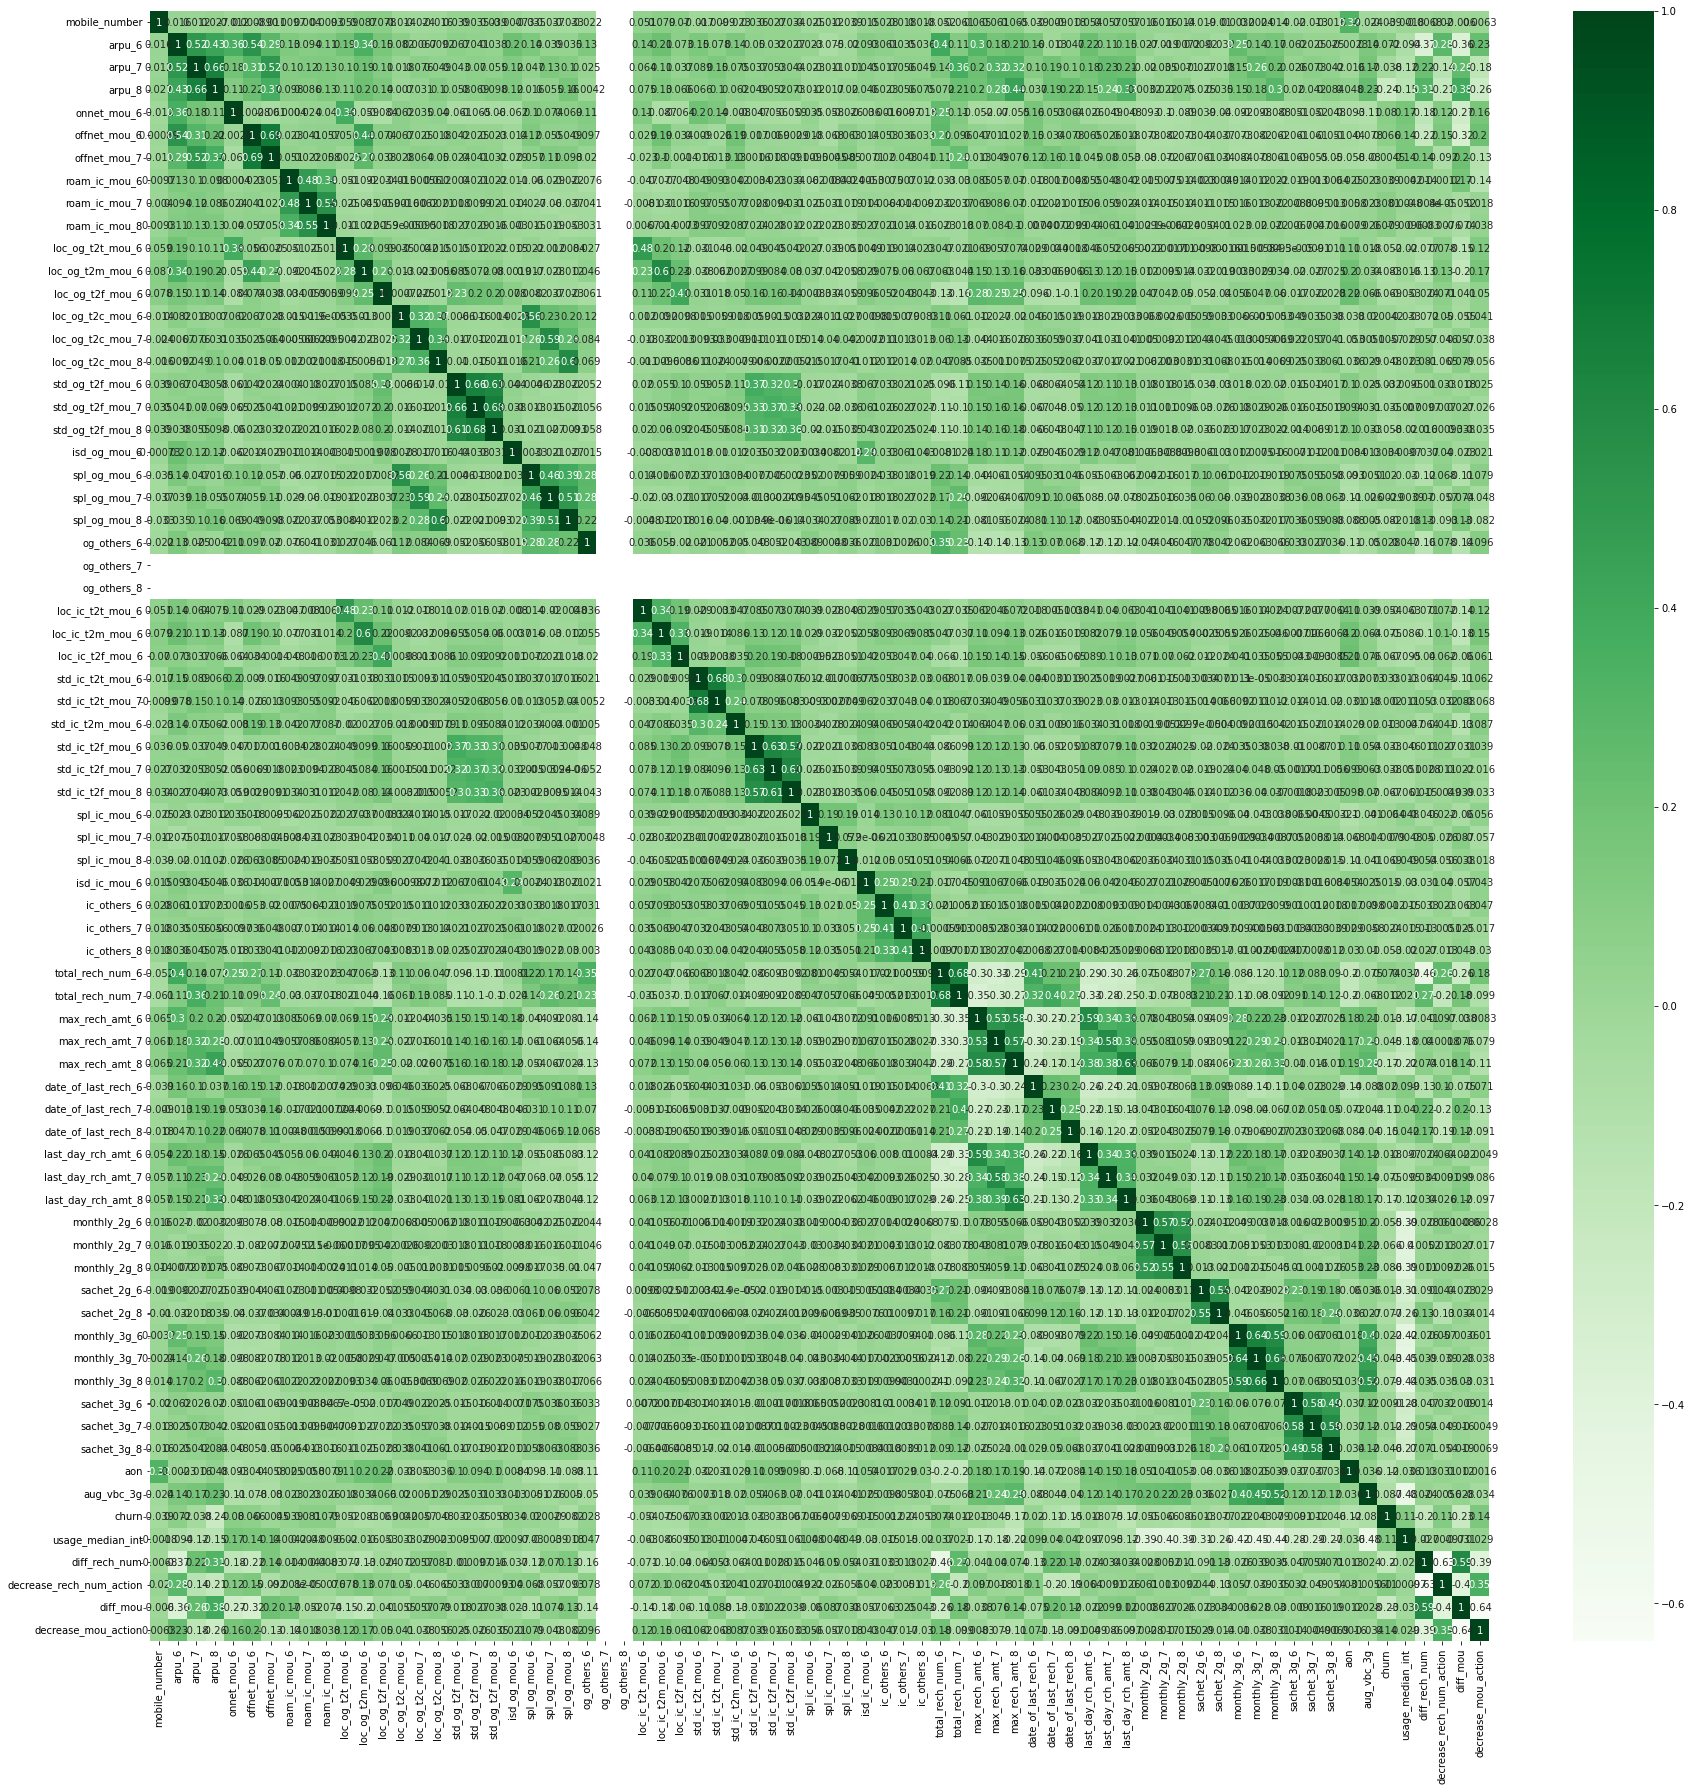

In [22]:
#Correlation Matrix

# Creation
correlation_matrix = telecom_outlier_prep.corr().abs()

# Select upper triangle of correlation matrix
upper_matrix_col = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
drop_cols = [column for column in upper_matrix_col.columns if any(upper_matrix_col[column] > 0.7)]

telecom_outlier_prep = telecom_outlier_prep.drop(drop_cols, 1)

plt.figure(figsize=(30,30))
sns.heatmap(telecom_outlier_prep.corr(),cbar=True,annot=True,cmap='Greens')

In [23]:
# Creating dummy variables
#telecom_outlier_prep = pd.get_dummies(telecom_outlier_prep, drop_first=True)

In [24]:
#telecom_outlier_prep.rename(columns={"tenure_buck_(1, 2]": "tenure_buck_1_to_2","tenure_buck_(2, 3]":"tenure_buck_2_to_3",
#                   "tenure_buck_(3, 4]":"tenure_buck_3_to_4",
#                   "tenure_buck_(4, 10]":"tenure_buck_4_to_10"}, inplace=True)

In [25]:
telecom_outlier_prep.shape

(29979, 72)

In [26]:
# After outlier treatment droping column which have zero variance
telecom_preped_data = telecom_outlier_prep.drop(['og_others_7','og_others_8','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','aon'], 1)

In [27]:
telecom_preped_data.shape

(29979, 66)

## Modelling

- Conduct appropriate exploratory analysis to extract useful insights (whether directly useful for business or for eventual modelling/feature engineering).

- Train a variety of models, tune model hyperparameters, etc. (handle class imbalance using appropriate techniques).

- Evaluate the models using appropriate evaluation metrics. Note that it is more important to identify churners than the non-churners accurately - choose an appropriate evaluation metric which reflects this business goal.

- Finally, choose a model based on some evaluation metric.

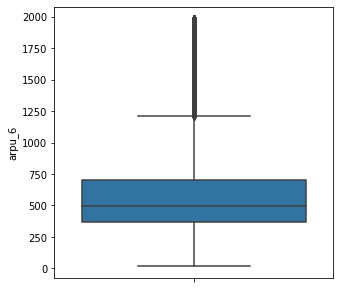

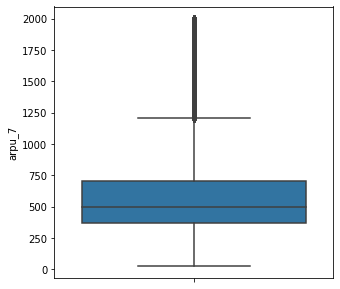

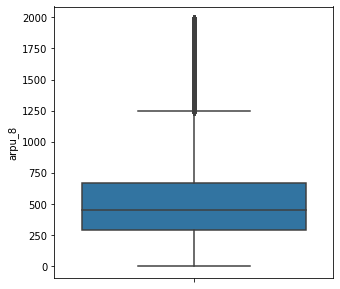

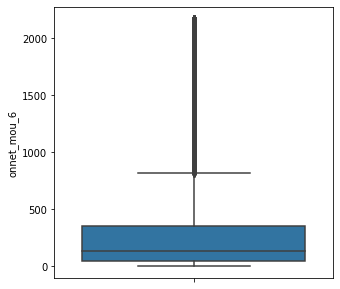

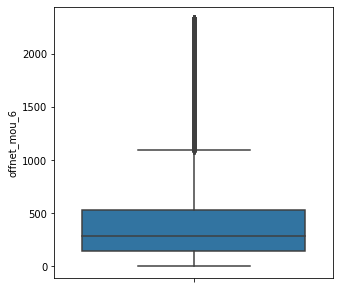

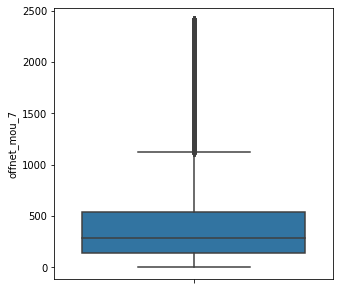

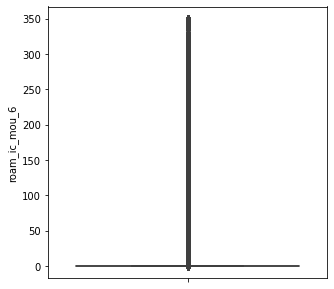

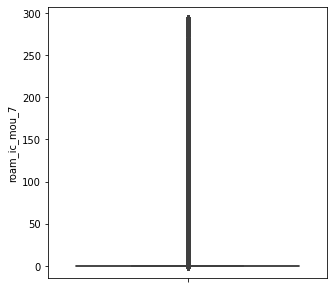

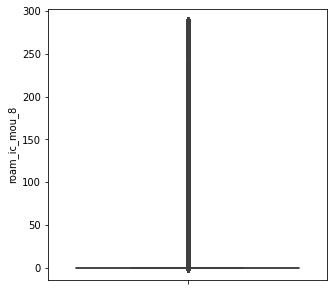

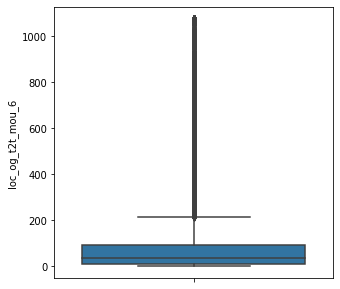

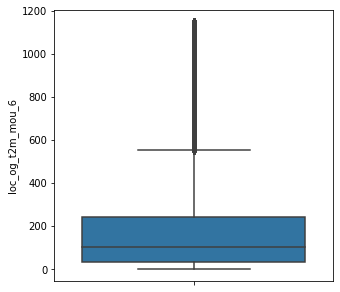

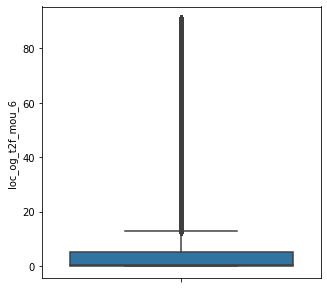

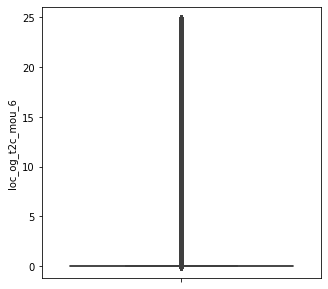

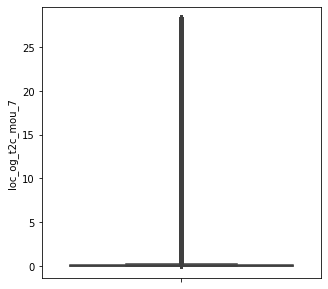

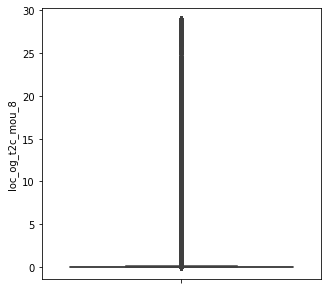

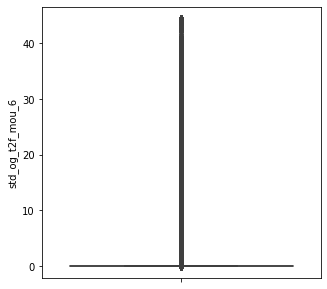

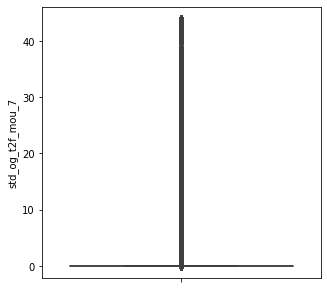

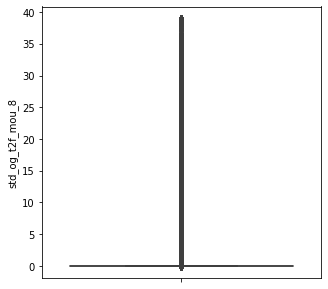

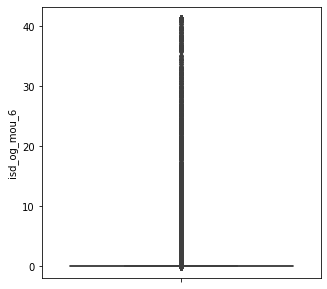

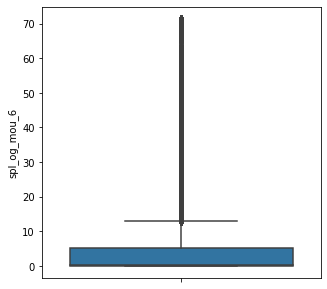

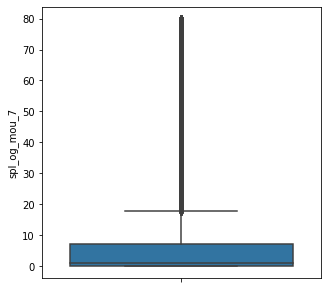

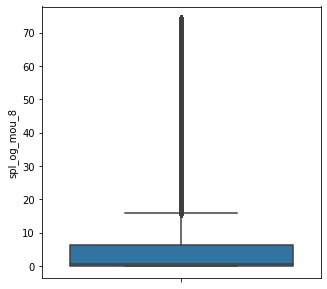

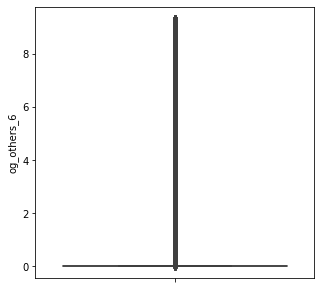

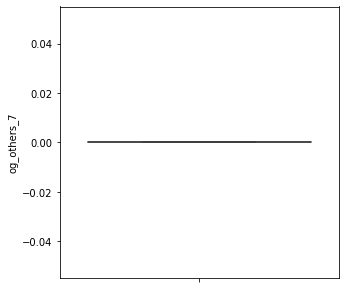

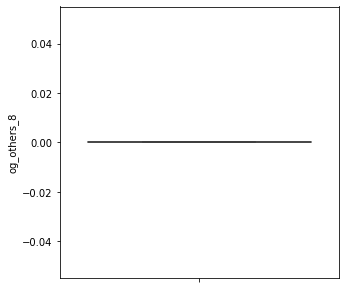

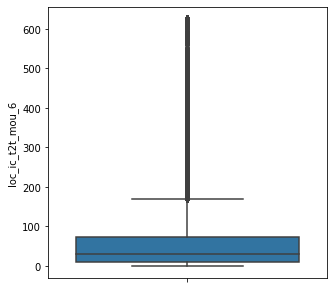

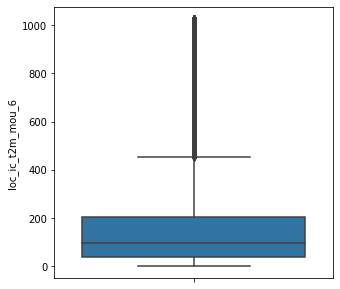

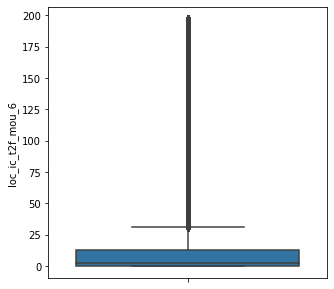

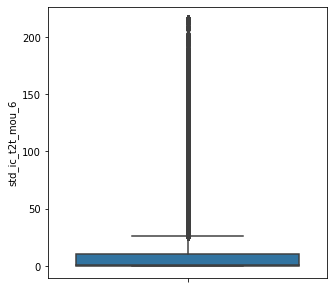

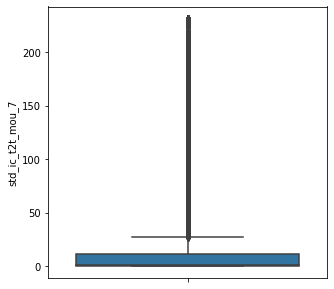

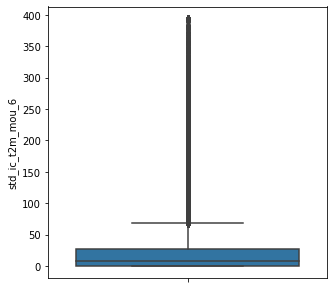

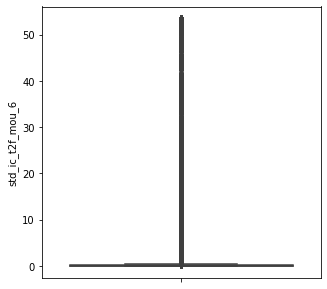

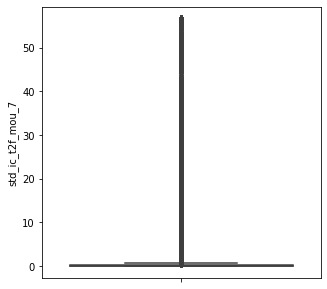

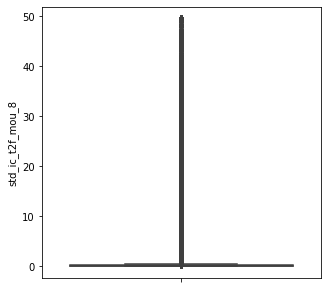

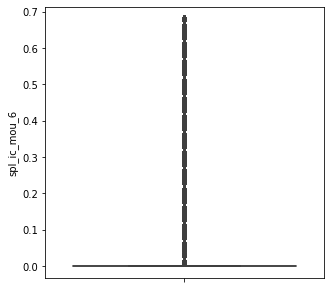

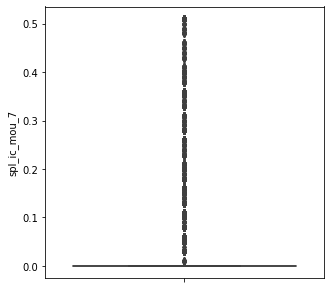

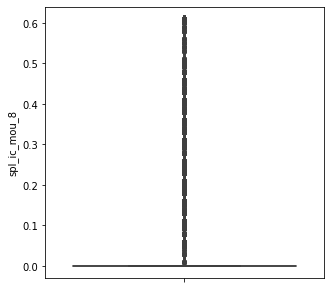

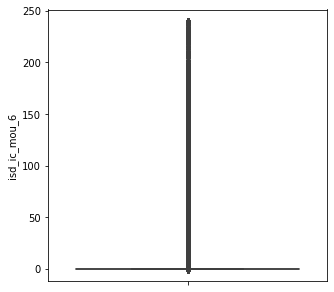

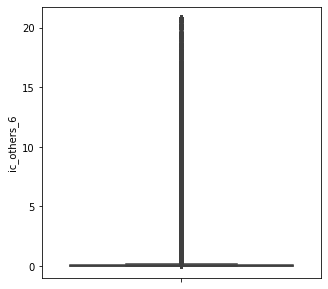

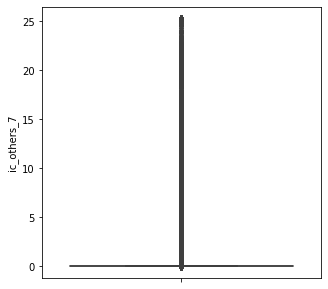

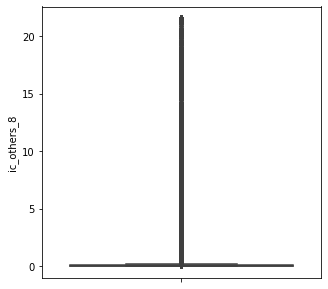

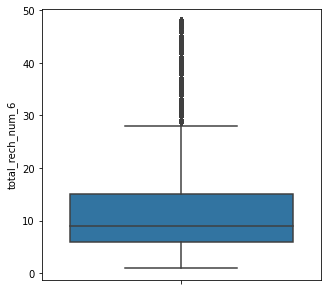

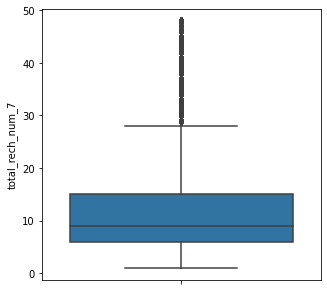

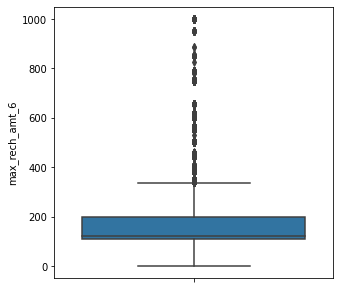

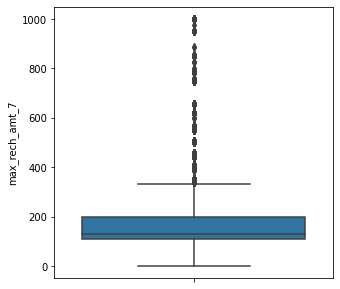

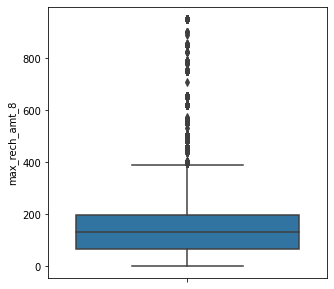

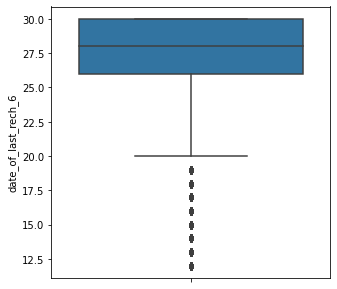

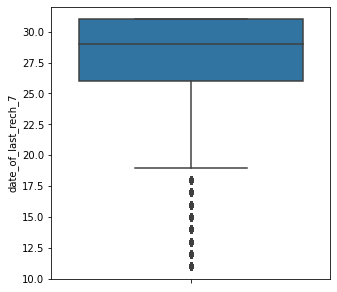

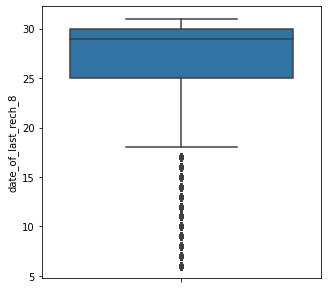

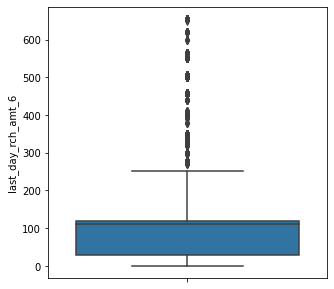

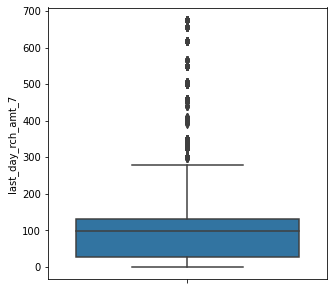

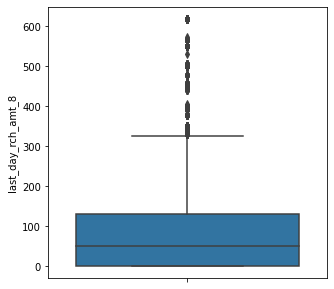

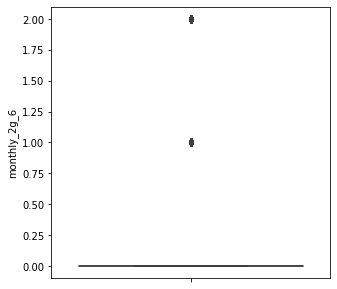

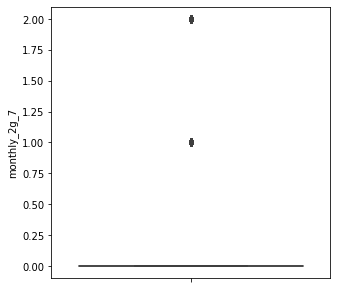

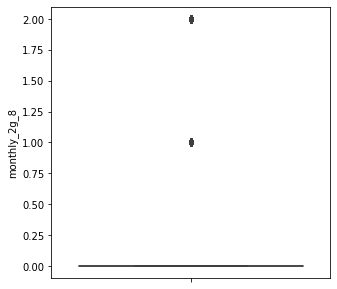

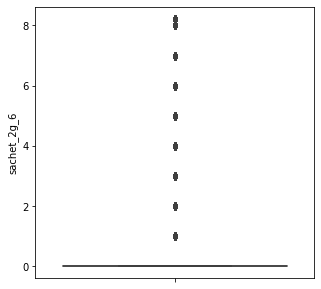

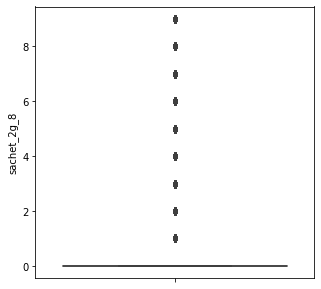

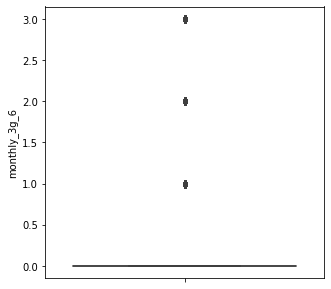

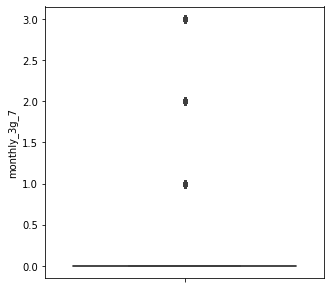

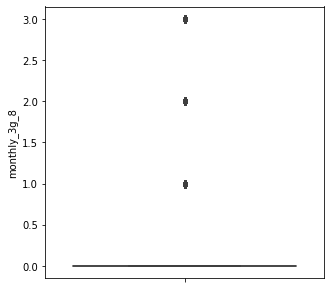

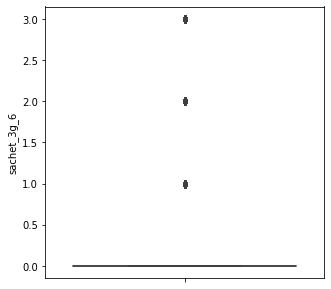

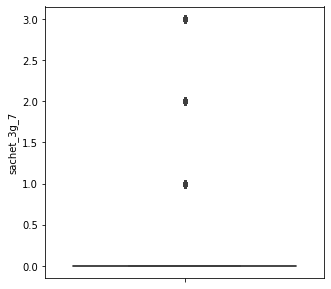

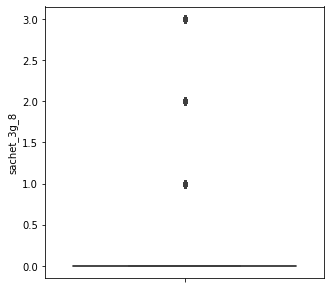

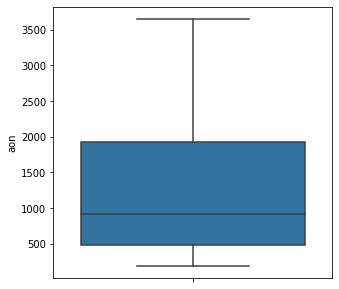

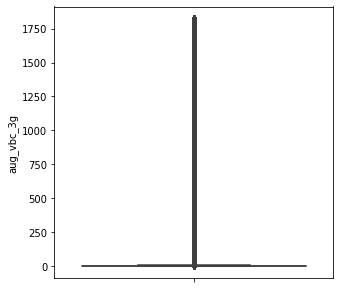

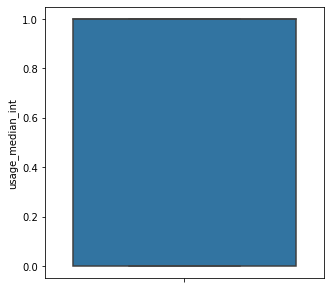

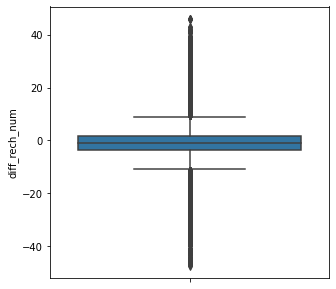

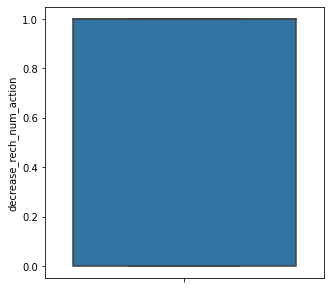

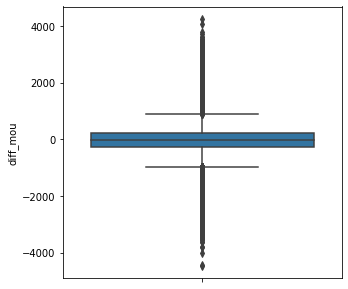

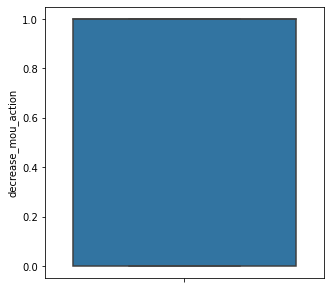

In [28]:
# Exploratory Data Analysis

#Univariate Analysis
cont_cols = [col for col in telecom_outlier_prep.columns if col not in ['churn','mobile_number']]
for col in cont_cols:
    plt.figure(figsize=(5, 5))
    sns.boxplot(y=col, data=telecom_outlier_prep)

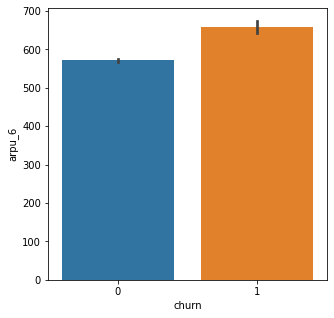

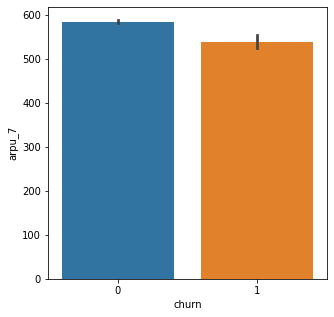

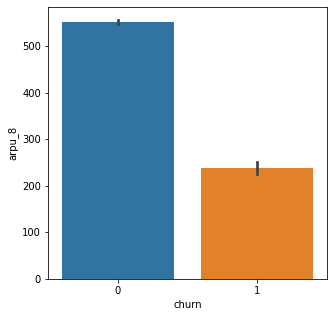

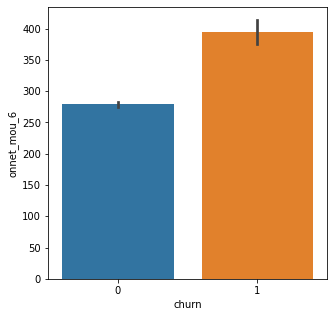

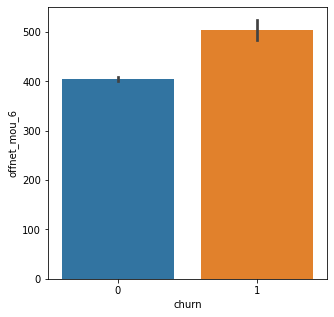

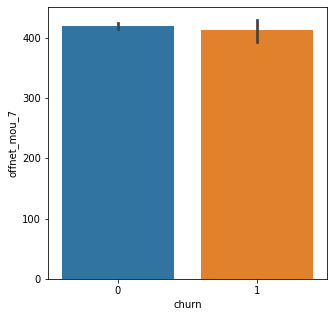

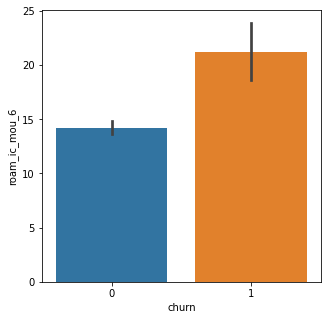

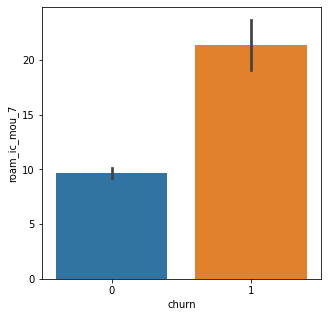

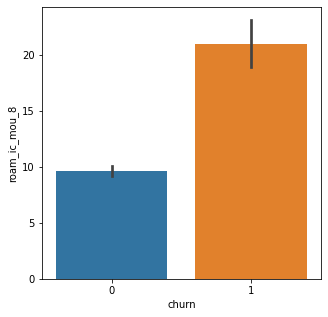

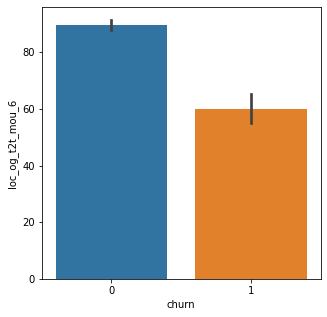

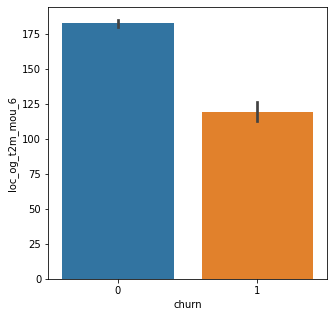

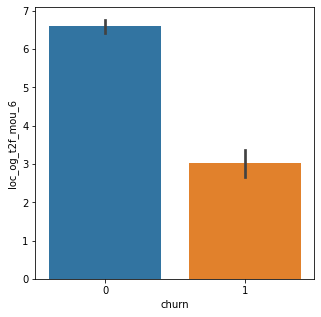

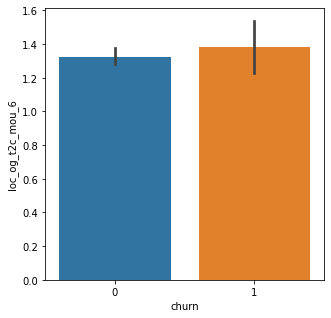

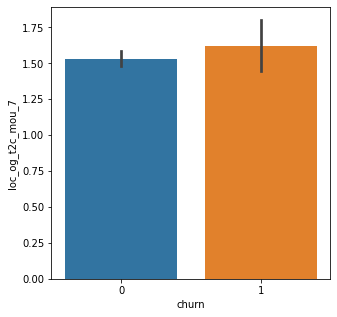

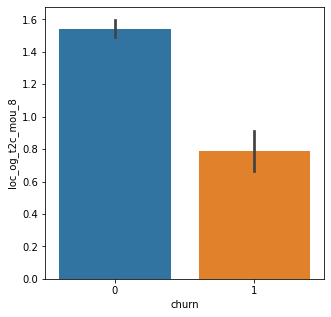

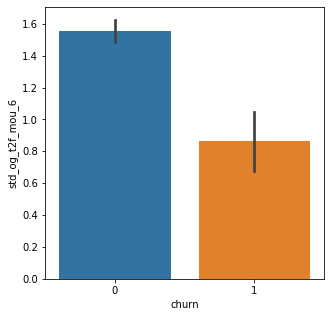

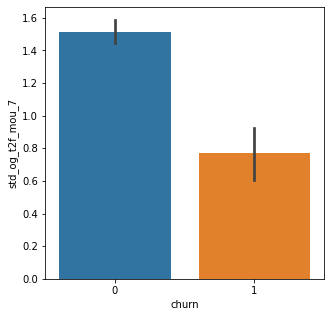

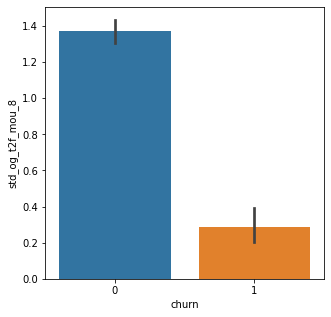

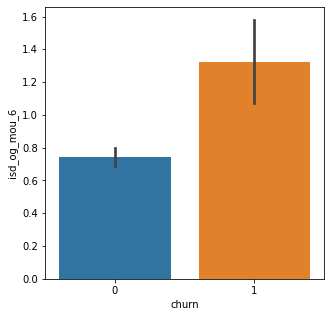

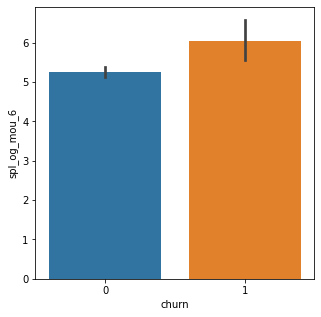

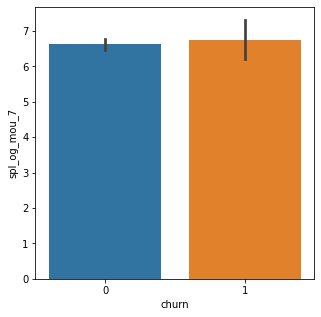

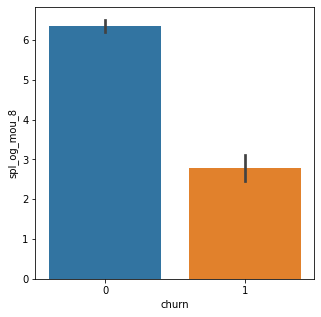

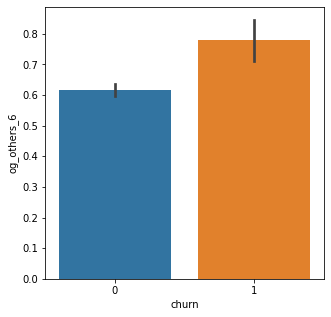

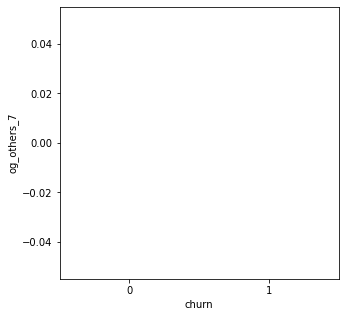

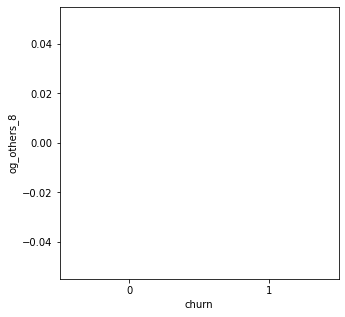

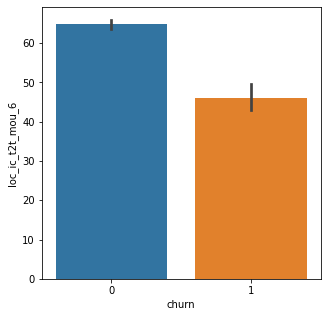

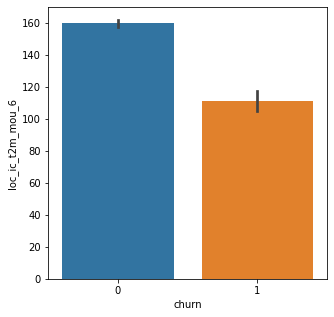

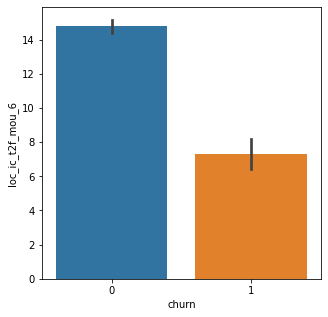

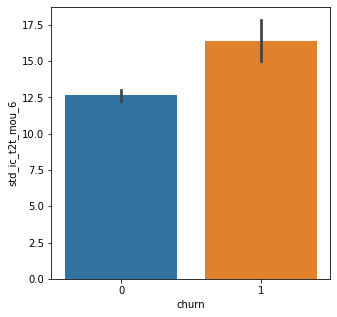

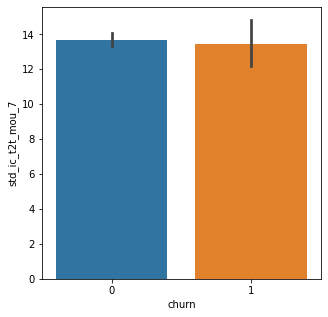

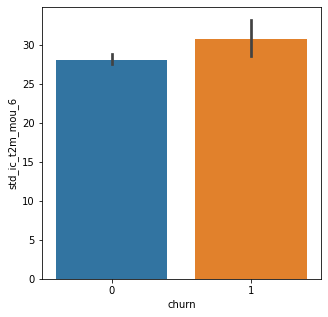

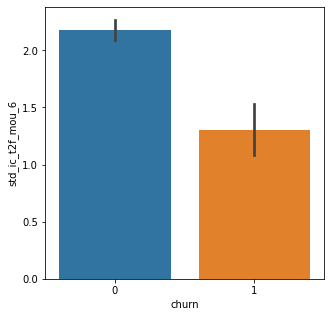

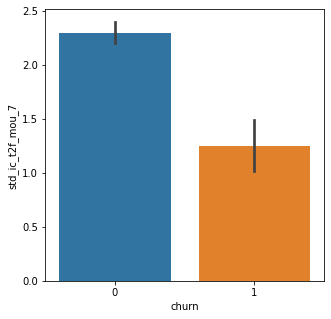

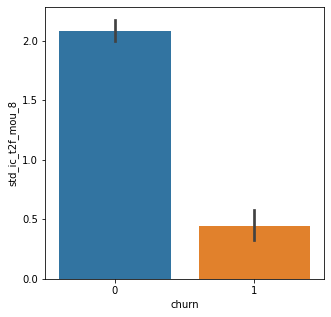

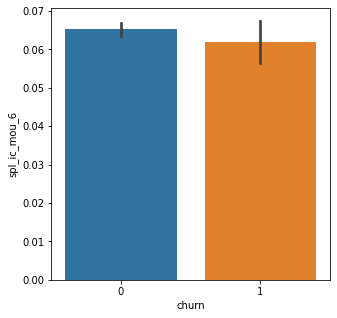

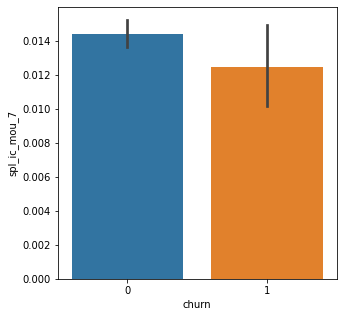

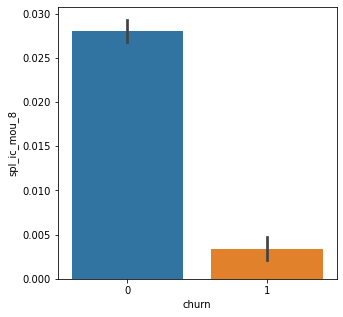

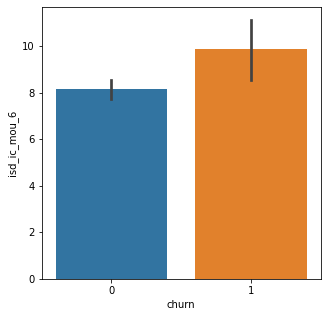

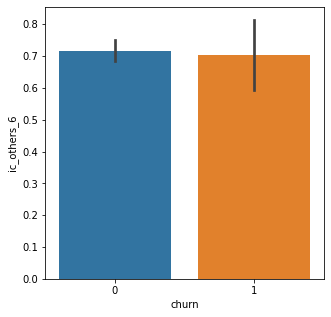

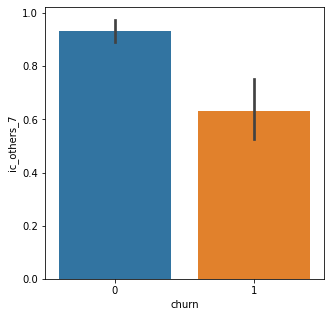

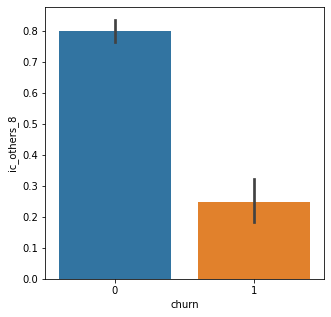

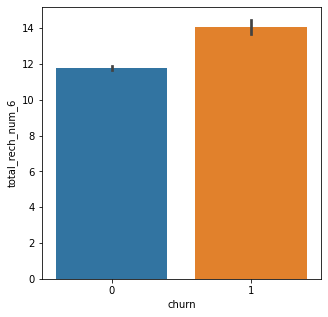

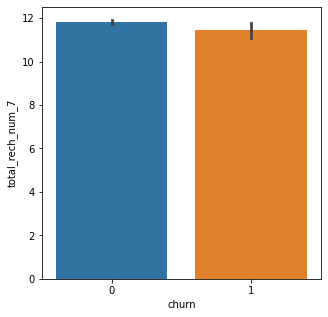

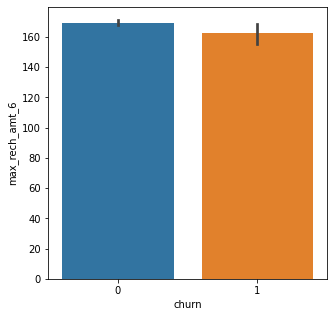

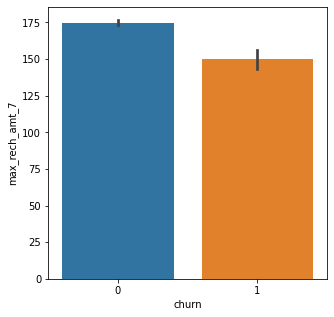

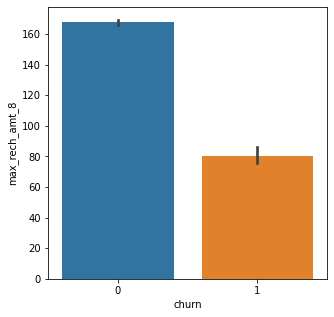

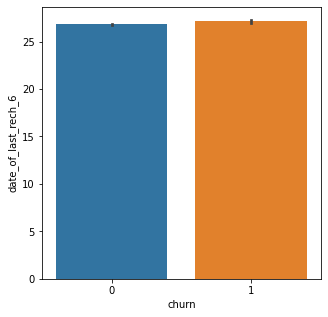

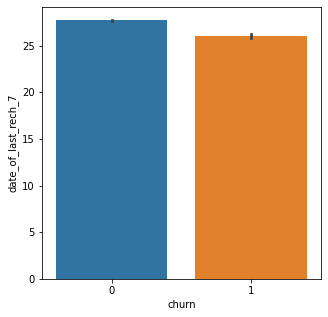

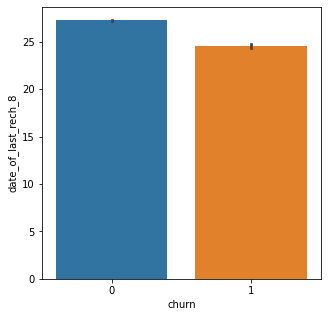

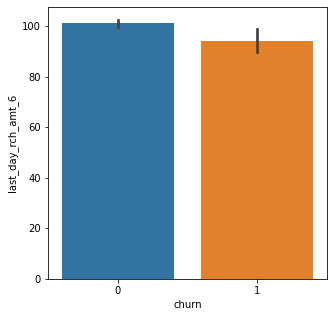

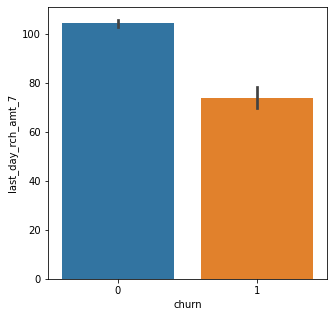

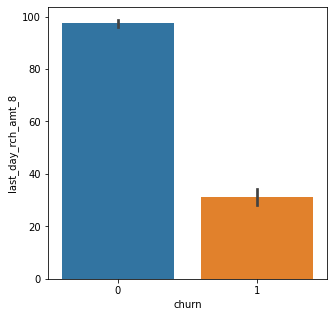

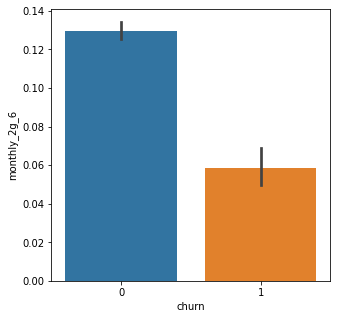

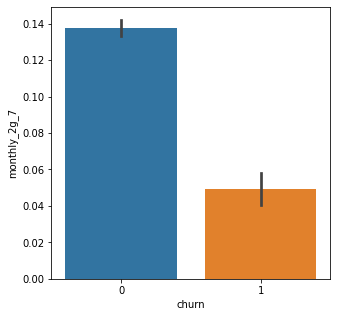

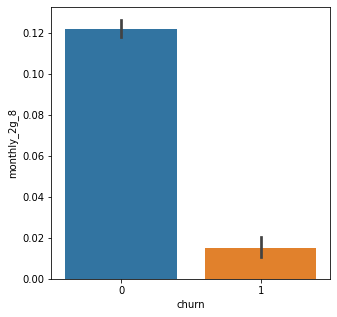

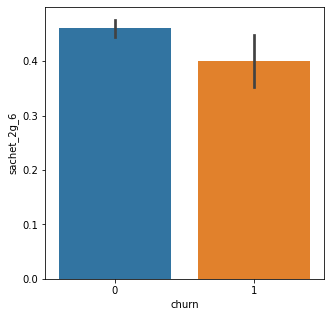

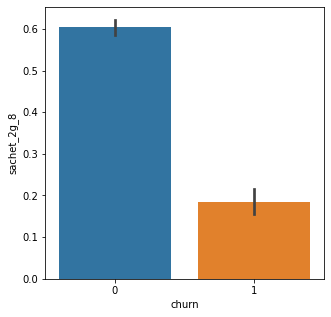

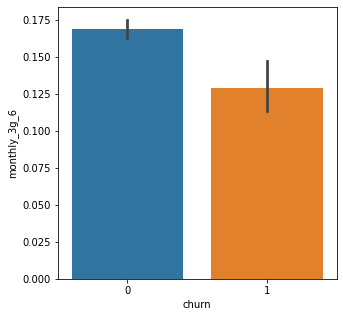

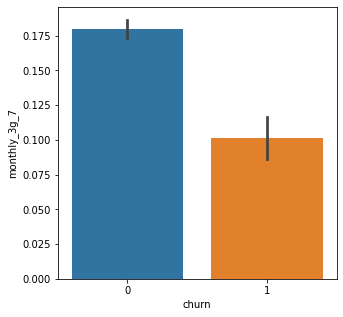

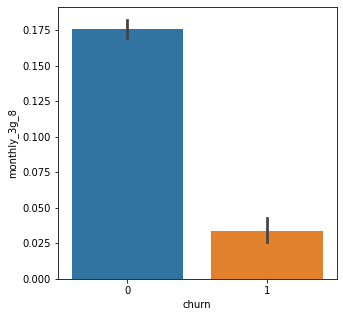

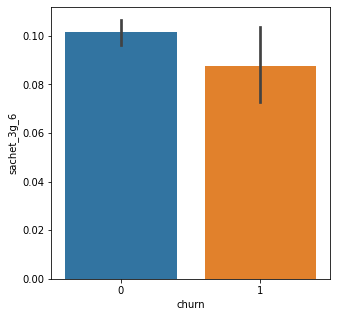

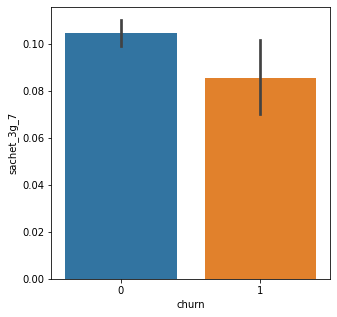

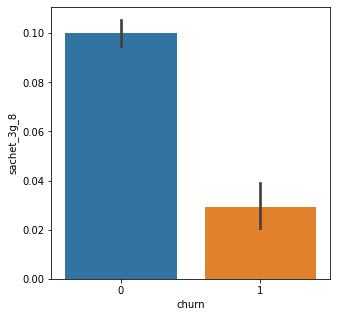

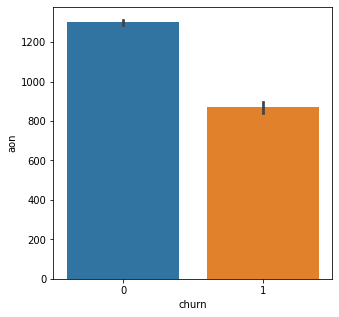

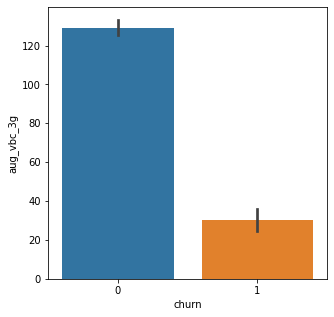

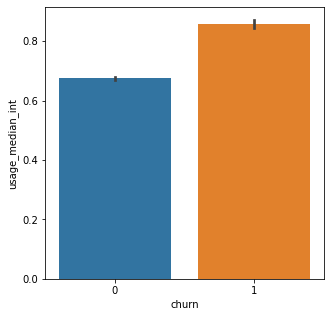

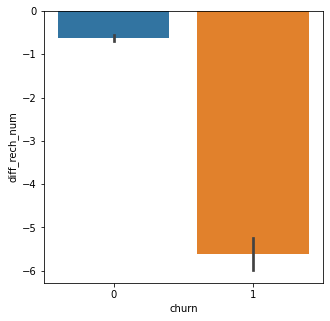

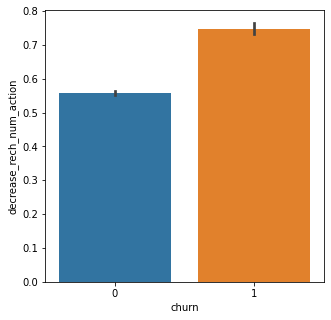

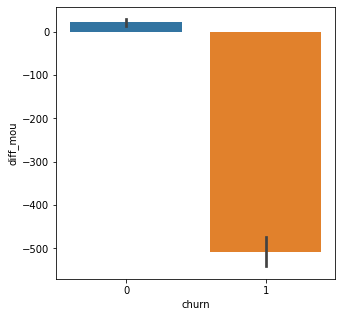

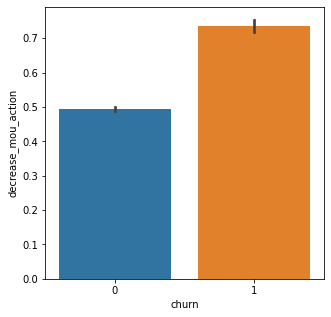

In [29]:
#Bivariate Analysis
cont_cols = [col for col in telecom_outlier_prep.columns if col not in ['churn','mobile_number']]
for col in cont_cols:
    plt.figure(figsize=(5, 5))
    sns.barplot(x='churn', y=col, data=telecom_outlier_prep)
    plt.show()

[Text(0, 0.5, '(%)')]

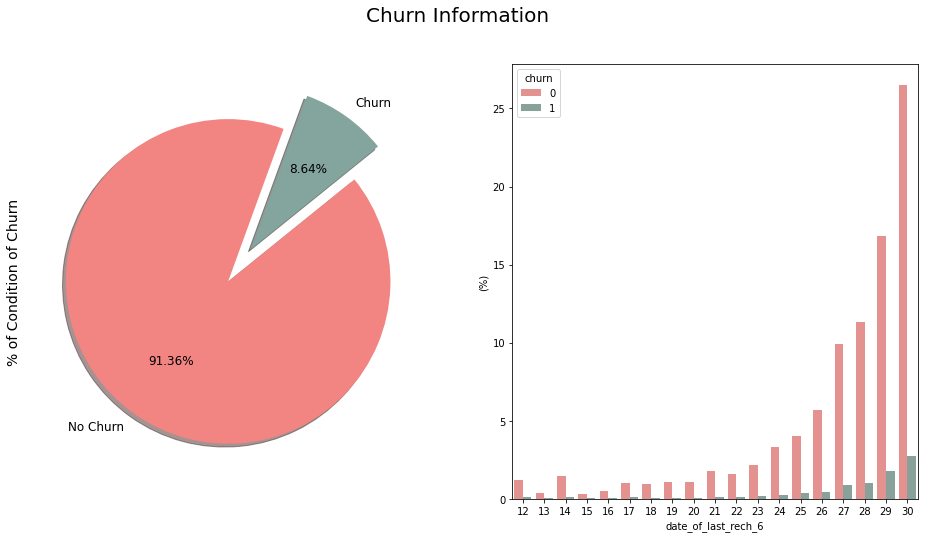

In [30]:
f, ax = plt.subplots(1,2, figsize=(16,8))
colors = ["#f28482", "#84a59d"]

labels ="No Churn", "Churn"
plt.suptitle('Churn Information', fontsize=20)

telecom_outlier_prep["churn"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)
ax[0].set_ylabel('% of Condition of Churn', fontsize=14)

sns.barplot(x="date_of_last_rech_6", y="churn", hue="churn", data=telecom_outlier_prep, palette=colors, estimator=lambda x: len(x) / len(telecom_outlier_prep) * 100)
ax[1].set(ylabel="(%)")

<AxesSubplot:xlabel='date_of_last_rech_8', ylabel='churn'>

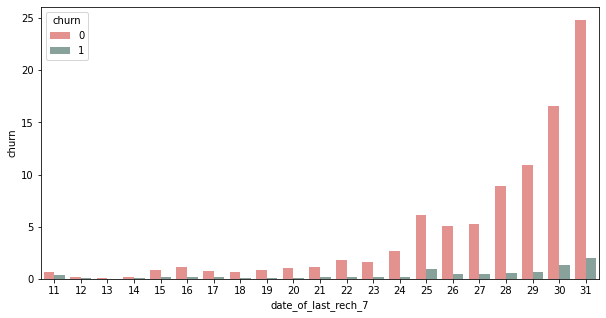

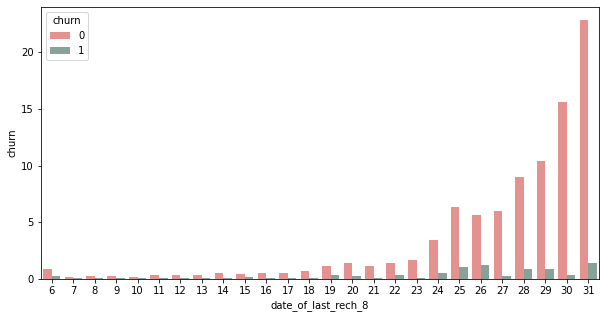

In [31]:
plt.figure(figsize=(10,5))
sns.barplot(x="date_of_last_rech_7", y="churn", hue="churn", data=telecom_outlier_prep, palette=colors, 
            estimator=lambda x: len(x) / len(telecom_outlier_prep) * 100)

plt.figure(figsize=(10,5))
sns.barplot(x="date_of_last_rech_8", y="churn", hue="churn", data=telecom_outlier_prep, palette=colors, 
            estimator=lambda x: len(x) / len(telecom_outlier_prep) * 100)

## TRAIN- TEST SPLIT

In [32]:
# Import library
from sklearn.model_selection import train_test_split

In [33]:
# Putting feature variables into X
X = telecom_preped_data.drop(['mobile_number','churn'], axis=1)

In [34]:
# Putting target variable to y
y = telecom_preped_data['churn']

In [35]:
#Splitting data into train and test set 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

## CHECKING FOR DATA IMBALANCE

In [36]:
telecom_preped_data['churn'].value_counts(normalize=True)

0    0.91364
1    0.08636
Name: churn, dtype: float64

# we can see that there is heavy data imbalance

In [37]:
# Imporing SMOTE
from imblearn.over_sampling import SMOTE

In [38]:
# Instantiate SMOTE
sm = SMOTE(random_state=27)

In [39]:
# Fittign SMOTE to the train set
X_train, y_train = sm.fit_resample(X_train, y_train)

In [40]:
# Standardization method
from sklearn.preprocessing import StandardScaler

In [41]:
# Instantiate the Scaler
scaler = StandardScaler()

In [42]:
# List of the numeric columns
cols_scale = X_train.columns.to_list()

In [43]:
# Fit the data into scaler and transform
X_train[cols_scale] = scaler.fit_transform(X_train[cols_scale])

In [44]:
X_train.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,loc_og_t2t_mou_6,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,usage_median_int,diff_rech_num,decrease_rech_num_action,diff_mou,decrease_mou_action
0,-0.713664,-0.007965,-0.339925,-0.666325,0.027041,0.550841,-0.307776,-0.318488,-0.325756,-0.481734,...,-0.241254,-0.206967,-0.204615,-0.172243,-0.300037,0.617639,0.749391,-1.24276,0.492335,-1.213358
1,0.396971,-0.038894,0.571003,-0.645996,0.258305,-0.195166,0.698875,-0.318488,-0.055153,-0.298748,...,-0.241254,-0.206967,-0.204615,-0.172243,1.130524,-1.619068,0.566549,-1.24276,0.430777,-1.213358
2,1.191212,1.654064,1.418665,-0.616537,-0.741296,-0.407287,-0.307776,-0.318488,-0.325756,-0.103629,...,4.936707,-0.206967,-0.204615,-0.172243,-0.300037,-1.619068,0.627497,-1.24276,0.518339,-1.213358
3,-0.038923,-0.497597,0.665377,0.572623,-0.860408,-0.795981,-0.307776,-0.318488,-0.325756,-0.252431,...,-0.241254,-0.206967,-0.204615,-0.172243,-0.300037,0.617639,0.444655,-1.24276,0.092348,0.824159
4,-0.250825,0.370899,1.265042,-0.291015,-0.217948,0.189608,-0.307776,-0.318488,-0.325756,-0.284672,...,-0.241254,-0.206967,-0.204615,-0.172243,-0.300037,-1.619068,0.627497,-1.24276,0.968465,-1.213358


In [45]:
# Transform the test set
X_test[cols_scale] = scaler.transform(X_test[cols_scale])
X_test.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,loc_og_t2t_mou_6,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,usage_median_int,diff_rech_num,decrease_rech_num_action,diff_mou,decrease_mou_action
76438,0.841875,0.733827,1.684893,1.862581,0.638118,0.887580,-0.307776,-0.318488,-0.325756,6.718788,...,-0.241254,-0.206967,-0.204615,-0.172243,-0.300037,0.617639,0.018023,0.80466,0.427312,-1.213358
72869,-0.129683,-0.110248,0.432420,-0.316742,-0.228301,0.132193,0.546748,-0.318488,-0.325756,0.638371,...,-0.241254,-0.206967,-0.204615,-0.172243,-0.300037,0.617639,0.383707,-1.24276,0.595138,-1.213358
86053,-0.836192,-0.586894,-0.589649,-0.675878,-0.411605,-0.486091,-0.307776,-0.318488,-0.325756,-0.287822,...,-0.241254,-0.206967,-0.204615,-0.172243,-0.300037,0.617639,0.139918,0.80466,0.462892,-1.213358
29093,-0.945457,-0.415456,-0.041206,-0.709537,-0.409162,-0.310833,-0.307776,-0.318488,-0.325756,-0.476506,...,2.347727,2.504539,7.696024,-0.172243,-0.292098,-1.619068,0.566549,-1.24276,0.322100,-1.213358
96385,0.074613,0.682405,2.589859,0.467137,-0.607682,-0.662300,1.034488,2.197628,6.121726,-0.497687,...,-0.241254,-0.206967,-0.204615,-0.172243,-0.300037,0.617639,0.688444,-1.24276,0.337964,-1.213358


# Model with PCA

In [46]:
#Import PCA
from sklearn.decomposition import PCA
# Instantiate PCA
pca = PCA(random_state=42)
# Fit train set on PCA
pca.fit(X_train)

PCA(random_state=42)

In [47]:
# Principal components
pca.components_

array([[ 0.0125247 ,  0.1808743 ,  0.24591106, ..., -0.12170874,
         0.1810276 , -0.15377733],
       [ 0.27918219, -0.06734839, -0.10362062, ...,  0.27878017,
        -0.34037482,  0.26975519],
       [ 0.21413724,  0.23330983,  0.19621032, ...,  0.01774116,
        -0.02929836,  0.0368317 ],
       ...,
       [-0.67407603,  0.32849891,  0.21446095, ...,  0.02091098,
        -0.19391038, -0.02385011],
       [ 0.04558021, -0.04587519, -0.30534054, ..., -0.02554244,
         0.64392205,  0.05228985],
       [ 0.00908008,  0.08248943, -0.1751128 , ...,  0.01355823,
        -0.00523394,  0.00214368]])

In [48]:
# Cumuliative varinace of the PCs
variance_cumu = np.cumsum(pca.explained_variance_ratio_)
print(variance_cumu)

[0.10039211 0.16963927 0.23236977 0.28093051 0.32654697 0.36402907
 0.39959653 0.43200443 0.46095674 0.48958166 0.51709926 0.54182077
 0.5637383  0.58351294 0.60234726 0.62042792 0.63776052 0.65483126
 0.67032581 0.6848373  0.69908591 0.71298623 0.72625714 0.73886839
 0.75091712 0.76212965 0.77289505 0.78337653 0.7935509  0.8033412
 0.81284747 0.82203848 0.83088034 0.83953478 0.84810807 0.85654619
 0.86458795 0.87246718 0.88020053 0.88750651 0.89457808 0.90146756
 0.90828066 0.91490956 0.92137007 0.92745547 0.93324741 0.93892776
 0.9445214  0.94991948 0.9550522  0.95995961 0.96481425 0.96962066
 0.97427626 0.97880358 0.98306135 0.98708144 0.99067574 0.99402361
 0.99673435 0.99857741 0.99968586 1.        ]


Text(0, 0.5, 'Cumulative Variance')

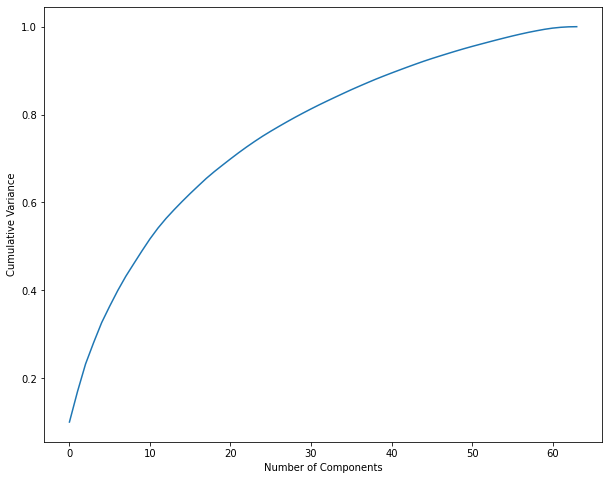

In [49]:
# Plotting scree plot
fig = plt.figure(figsize = (10,8))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

### we can see that 50 components explain almost more than 90% variance of the data. So we will perform PCA with 50 components

In [50]:
from sklearn.decomposition import PCA
pca_final = PCA(n_components=50,random_state=100)

# Fit and transform the X_train
X_train_pca = pca_final.fit_transform(X_train)

### Applying transformation on the test set
We are only doing Transform in the test set not the Fit-Transform. Because the Fitting is already done on the train set. So, we just have to do the transformation with the already fitted data on the train set.

In [51]:
X_test_pca = pca_final.transform(X_test)

## Logistic regression with PCA

In [52]:
# Importing scikit logistic regression module
from sklearn.linear_model import LogisticRegression
# Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [53]:
# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [54]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [55]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.105068,0.010004,0.003195,0.000770,0.01,{'C': 0.01},0.879926,0.862848,0.877537,0.866712,...,0.870744,0.006715,1,0.869861,0.872218,0.869464,0.870922,0.871498,0.870793,0.001018
1,0.120476,0.005056,0.002263,0.000102,0.1,{'C': 0.1},0.879465,0.862163,0.877309,0.867391,...,0.870470,0.006723,2,0.870032,0.872901,0.869635,0.870808,0.872468,0.871169,0.001301
2,0.126511,0.005975,0.002507,0.000318,1,{'C': 1},0.879004,0.862163,0.877537,0.867391,...,0.870378,0.006680,3,0.869861,0.873015,0.870033,0.871036,0.872297,0.871248,0.001238
3,0.118909,0.002847,0.002629,0.000640,10,{'C': 10},0.879004,0.861935,0.877537,0.867391,...,0.870332,0.006736,4,0.869861,0.873072,0.870147,0.871036,0.872297,0.871283,0.001233
4,0.120773,0.005130,0.002600,0.000398,100,{'C': 100},0.879004,0.861935,0.877537,0.867391,...,0.870332,0.006736,4,0.869861,0.873072,0.870147,0.871093,0.872297,0.871294,0.001231
5,0.118982,0.012352,0.002645,0.000599,1000,{'C': 1000},0.879004,0.861935,0.877537,0.867391,...,0.870332,0.006736,4,0.869861,0.873072,0.870147,0.871093,0.872240,0.871283,0.001222


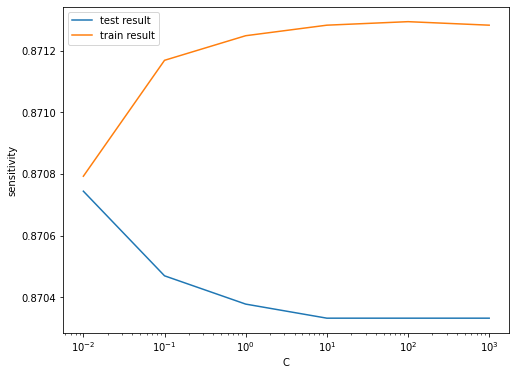

In [56]:
# plot of C versus train and validation scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [57]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test sensitivity is {0} at C = {1}".format(best_score, best_C))

 The highest test sensitivity is 0.8707440081013278 at C = 0.01


### Logistic regression with optimal C

In [58]:
# Instantiate the model with best C
logistic_pca = LogisticRegression(C=best_C)
# Fit the model on the train set
log_pca_model = logistic_pca.fit(X_train_pca, y_train)

# Predictions on the train set
y_train_pred = log_pca_model.predict(X_train_pca)



In [59]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

[[18725  3226]
 [ 2845 19106]]


In [60]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [61]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8617147282583937
Sensitivity:- 0.8703931483759282
Specificity:- 0.8530363081408592


In [62]:
# Prediction on the test set
y_test_pred = log_pca_model.predict(X_test_pca)

In [63]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)


[[4594  845]
 [ 163  394]]


In [64]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [65]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8318879252835224
Sensitivity:- 0.7073608617594255
Specificity:- 0.8446405589262732


## DT with PCA

In [66]:
# Importing decision tree classifier
from sklearn.tree import DecisionTreeClassifier

In [67]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'recall',
                           cv = 5, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_pca,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='recall', verbose=1)

In [68]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.795182,0.005780,0.002570,0.000147,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.798178,0.796174,0.782460,0.777449,0.763781,0.783608,0.012669,7
1,0.792668,0.002300,0.002513,0.000133,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.798178,0.796174,0.782460,0.777449,0.763781,0.783608,0.012669,7
2,0.788718,0.001794,0.002500,0.000082,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.801367,0.796174,0.783371,0.779043,0.763781,0.784747,0.013272,5
3,0.814071,0.022969,0.002645,0.000115,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.801367,0.796174,0.783371,0.779043,0.763781,0.784747,0.013272,5
4,1.378822,0.030406,0.002779,0.000121,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.779043,0.833979,0.833030,0.846469,0.839863,0.826477,0.024199,1
5,1.328419,0.006729,0.002824,0.000034,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.779043,0.833979,0.833030,0.845558,0.838724,0.826067,0.023927,2
6,1.257260,0.010132,0.002768,0.000098,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.774032,0.836028,0.828474,0.848292,0.841002,0.825566,0.026565,3
7,1.255077,0.009876,0.002771,0.000117,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.774032,0.836028,0.828474,0.848292,0.841002,0.825566,0.026565,3


In [69]:
# Printing the optimal sensitivity score and hyperparameters
print("Best sensitivity:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best sensitivity:- 0.8264768119092221
DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)


In [70]:
# Model with optimal hyperparameters
dt_pca_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

dt_pca_model.fit(X_train_pca, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50,
                       random_state=100)

In [71]:
# Predictions on the train set
y_train_pred = dt_pca_model.predict(X_train_pca)

In [72]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

[[18221  3730]
 [ 2788 19163]]


In [73]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [74]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8515329597740422
Sensitivity:- 0.8729898410095213
Specificity:- 0.8300760785385631


In [75]:
# Prediction on the test set
y_test_pred = dt_pca_model.predict(X_test_pca)

In [76]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4386 1053]
 [ 177  380]]


In [77]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [78]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.794863242161441
Sensitivity:- 0.6822262118491921
Specificity:- 0.8063982349696636


## Random Forest with PCA

In [79]:
# Importing random forest classifier
from sklearn.ensemble import RandomForestClassifier

In [80]:
param_grid = {
    'max_depth': range(5,10,5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'n_estimators': [100,200,300], 
    'max_features': [10, 20]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1,
                           verbose = 1, 
                           return_train_score=True)

# Fit the model
grid_search.fit(X_train_pca, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(5, 10, 5), 'max_features': [10, 20],
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50),
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, verbose=1)

In [81]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8109881098810988 using {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 300}


In [82]:
# model with the best hyperparameters

rfc_model = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50, 
                             min_samples_split=50,
                             max_features=10,
                             n_estimators=200)

In [83]:
# Fit the model
rfc_model.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=5, max_features=10, min_samples_leaf=50,
                       min_samples_split=50, n_estimators=200)

In [84]:
# Predictions on the train set
y_train_pred = rfc_model.predict(X_train_pca)

In [85]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

[[18175  3776]
 [ 4322 17629]]


In [86]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [87]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8155437109926654
Sensitivity:- 0.8031069199580885
Specificity:- 0.8279805020272425


In [88]:
# Prediction on the test set
y_test_pred = rfc_model.predict(X_test_pca)

In [89]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4442  997]
 [ 178  379]]


In [90]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [91]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8040360240160107
Sensitivity:- 0.6804308797127468
Specificity:- 0.8166942452656738


### On comparing the the PCA model with Logistic Regression, Decision Tree and Random Forest, We find that the PCA with Logistic Regression with better accuracy (86%) and sensitivity (87%) on training set and accuracy of 80 and sensitivity of 71 on test set

# Without PCA

## Logistic Regression with No PCA

In [92]:
##### Importing stats model
import statsmodels.api as sm

In [93]:
# Instantiate the model
# Adding the constant to X_train
log_no_pca = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())

In [94]:
# Fit the model
log_no_pca = log_no_pca.fit().summary()

In [95]:
# Summary
log_no_pca

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43902
Model:                            GLM   Df Residuals:                    43837
Model Family:                Binomial   Df Model:                           64
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15490.
Date:                Wed, 02 Mar 2022   Deviance:                       30981.
Time:                        20:49:16   Pearson chi2:                 1.26e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4937
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.2859      0.018    -16.110      0.000      -0.321      -0.251
arpu_6                       0.3733      0.036     10.466      0.000       0.303       0.443
arpu_7                       0.6643      0.034     19.622      0.000       0.598       0.731
arpu_8                      -0.3100      0.039     -8.026      0.000      -0.386      -0.234
onnet_mou_6                 -0.3051      0.026    -11.530      0.000      -0.357      -0.253
offnet_mou_6                -0.4097      0.038    -10.781      0.000      -0.484      -0.335
offnet_mou_7                 0.1944      0.030      6.408      0.000       0.135       0.254
roam_ic_mou_6               -0.0151      0.021     -0.719      0.472      -0.056       0.026
roam_ic_mou_7               -0.0046      0.023     -0.205      0.838      -0.049       0.040
roam_ic_mou_8                0.3473      0.021     16.931      0.000       0.307       0.388
loc_og_t2t_mou_6            -0.1268      0.020     -6.238      0.000      -0.167      -0.087
loc_og_t2m_mou_6            -0.3559      0.023    -15.517      0.000      -0.401      -0.311
loc_og_t2f_mou_6            -0.1860      0.021     -8.689      0.000      -0.228      -0.144
loc_og_t2c_mou_6            -0.0714      0.019     -3.769      0.000      -0.109      -0.034
loc_og_t2c_mou_7             0.0491      0.021      2.382      0.017       0.009       0.090
loc_og_t2c_mou_8             0.0855      0.021      4.120      0.000       0.045       0.126
std_og_t2f_mou_6            -0.0112      0.021     -0.532      0.595      -0.052       0.030
std_og_t2f_mou_7            -0.0030      0.023     -0.129      0.898      -0.048       0.042
std_og_t2f_mou_8            -0.1008      0.025     -4.028      0.000      -0.150      -0.052
isd_og_mou_6                -0.0251      0.018     -1.395      0.163      -0.060       0.010
spl_og_mou_6                -0.0234      0.021     -1.102      0.270      -0.065       0.018
spl_og_mou_7                 0.0557      0.024      2.329      0.020       0.009       0.103
spl_og_mou_8                -0.1803      0.024     -7.403      0.000      -0.228      -0.133
og_others_6                 -0.0228      0.017     -1.367      0.172      -0.055       0.010
loc_ic_t2t_mou_6            -0.1399      0.020     -6.928      0.000      -0.179      -0.100
loc_ic_t2m_mou_6            -0.1534      0.023     -6.656      0.000      -0.199      -0.108
loc_ic_t2f_mou_6            -0.1685      0.021     -8.093      0.000      -0.209      -0.128
std_ic_t2t_mou_6            -0.0549      0.022     -2.536      0.011      -0.097      -0.012
std_ic_t2t_mou_7             0.0902      0.020      4.473      0.000       0.051       0.130
std_ic_t2m_mou_6            -0.1134      0.017     -6.717      0.000      -0.146      -0.080
std_ic_t2f_mou

## Feature selection using RFE

In [96]:
# Importing logistic regression from sklearn
from sklearn.linear_model import LogisticRegression
# Intantiate the logistic regression
logreg = LogisticRegression()

In [97]:
# Importing RFE
from sklearn.feature_selection import RFE

# Intantiate RFE with 15 columns
rfe = RFE(logreg, n_features_to_select = 15)

# Fit the rfe model with train set
rfe = rfe.fit(X_train, y_train)

In [99]:
# RFE selected columns
rfe_cols = X_train.columns[rfe.support_]
print(rfe_cols)

Index(['arpu_7', 'loc_og_t2m_mou_6', 'total_rech_num_6', 'total_rech_num_7',
       'date_of_last_rech_8', 'last_day_rch_amt_8', 'monthly_2g_7',
       'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_7', 'monthly_3g_8',
       'usage_median_int', 'diff_rech_num', 'decrease_rech_num_action',
       'diff_mou'],
      dtype='object')


In [100]:
## Ist model 

# Adding constant to X_train
X_train_sm_1 = sm.add_constant(X_train[rfe_cols])

#Instantiate the model
log_no_pca_1 = sm.GLM(y_train, X_train_sm_1, family=sm.families.Binomial())

# Fit the model
log_no_pca_1 = log_no_pca_1.fit()

log_no_pca_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43902
Model:                            GLM   Df Residuals:                    43886
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17418.
Date:                Wed, 02 Mar 2022   Deviance:                       34836.
Time:                        20:49:24   Pearson chi2:                 1.08e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4472
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.2397      0.016    -14.889      0.000      -0.271      -0.208
arpu_7                       0.4543      0.019     24.467      0.000       0.418       0.491
loc_og_t2m_mou_6            -0.6151      0.016    -37.679      0.000      -0.647      -0.583
total_rech_num_6            -2.1720      0.055    -39.243      0.000      -2.281      -2.064
total_rech_num_7             1.3712      0.044     31.301      0.000       1.285       1.457
date_of_last_rech_8         -0.6110      0.017    -36.826      0.000      -0.644      -0.579
last_day_rch_amt_8          -0.8373      0.019    -44.802      0.000      -0.874      -0.801
monthly_2g_7                -0.6247      0.025    -24.762      0.000      -0.674      -0.575
monthly_2g_8                -0.7841      0.034    -23.226      0.000      -0.850      -0.718
sachet_2g_8                 -0.6185      0.024    -26.103      0.000      -0.665      -0.572
monthly_3g_7                -0.4356      0.022    -19.536      0.000      -0.479      -0.392
monthly_3g_8                -0.6941      0.031    -22.348      0.000      -0.755      -0.633
usage_median_int            -0.6379      0.020    -32.585      0.000      -0.676      -0.599
diff_rech_num               -2.4131      0.054    -44.279      0.000      -2.520      -2.306
decrease_rech_num_action    -0.5821      0.018    -32.390      0.000      -0.617      -0.547
diff_mou                    -0.8164      0.022    -37.121      0.000      -0.860      -0.773
============================================================================================
"""

# VIF

In [101]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [102]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values, i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,total_rech_num_6,12.28
12,diff_rech_num,11.13
3,total_rech_num_7,8.21
14,diff_mou,1.97
9,monthly_3g_7,1.90
10,monthly_3g_8,1.79
13,decrease_rech_num_action,1.65
11,usage_median_int,1.61
0,arpu_7,1.57
6,monthly_2g_7,1.54


In [103]:
# Removing total_rech_num_6 column 
log_cols = rfe_cols.to_list()
log_cols.remove('total_rech_num_6')
print(log_cols)

['arpu_7', 'loc_og_t2m_mou_6', 'total_rech_num_7', 'date_of_last_rech_8', 'last_day_rch_amt_8', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_7', 'monthly_3g_8', 'usage_median_int', 'diff_rech_num', 'decrease_rech_num_action', 'diff_mou']


# Model -2 

In [104]:
# Adding constant to X_train
X_train_sm_2 = sm.add_constant(X_train[log_cols])

#Instantiate the model
log_no_pca_2 = sm.GLM(y_train, X_train_sm_2, family=sm.families.Binomial())

# Fit the model
log_no_pca_2 = log_no_pca_2.fit()

log_no_pca_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43902
Model:                            GLM   Df Residuals:                    43887
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18353.
Date:                Wed, 02 Mar 2022   Deviance:                       36706.
Time:                        20:49:28   Pearson chi2:                 1.23e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4232
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.2287      0.016    -14.383      0.000      -0.260      -0.198
arpu_7                       0.4869      0.018     27.220      0.000       0.452       0.522
loc_og_t2m_mou_6            -0.6121      0.016    -38.665      0.000      -0.643      -0.581
total_rech_num_7            -0.2219      0.016    -14.206      0.000      -0.252      -0.191
date_of_last_rech_8         -0.8303      0.016    -51.525      0.000      -0.862      -0.799
last_day_rch_amt_8          -0.9600      0.019    -49.919      0.000      -0.998      -0.922
monthly_2g_7                -0.6129      0.025    -24.222      0.000      -0.662      -0.563
monthly_2g_8                -0.8277      0.034    -24.316      0.000      -0.894      -0.761
sachet_2g_8                 -0.7538      0.023    -32.124      0.000      -0.800      -0.708
monthly_3g_7                -0.3818      0.022    -17.294      0.000      -0.425      -0.339
monthly_3g_8                -0.7499      0.031    -23.976      0.000      -0.811      -0.689
usage_median_int            -0.6403      0.019    -33.786      0.000      -0.677      -0.603
diff_rech_num               -0.5452      0.024    -22.969      0.000      -0.592      -0.499
decrease_rech_num_action    -0.5315      0.017    -30.410      0.000      -0.566      -0.497
diff_mou                    -0.8143      0.021    -37.915      0.000      -0.856      -0.772
============================================================================================
"""

## checking VIF for model 2

In [105]:

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[log_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[log_cols].values, i) for i in range(X_train[log_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,diff_rech_num,2.38
13,diff_mou,1.97
8,monthly_3g_7,1.90
9,monthly_3g_8,1.79
12,decrease_rech_num_action,1.65
10,usage_median_int,1.61
0,arpu_7,1.55
5,monthly_2g_7,1.54
6,monthly_2g_8,1.52
2,total_rech_num_7,1.46


In [106]:
# Removing diff_mou column 

log_cols.remove('diff_rech_num')
print(log_cols)

['arpu_7', 'loc_og_t2m_mou_6', 'total_rech_num_7', 'date_of_last_rech_8', 'last_day_rch_amt_8', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_7', 'monthly_3g_8', 'usage_median_int', 'decrease_rech_num_action', 'diff_mou']


In [107]:
# Adding constant to X_train
X_train_sm_3 = sm.add_constant(X_train[log_cols])

#Instantiate the model
log_no_pca_3 = sm.GLM(y_train, X_train_sm_3, family=sm.families.Binomial())

# Fit the model
log_no_pca_3 = log_no_pca_3.fit()

log_no_pca_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43902
Model:                            GLM   Df Residuals:                    43888
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18646.
Date:                Wed, 02 Mar 2022   Deviance:                       37292.
Time:                        20:49:31   Pearson chi2:                 1.47e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4154
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.2526      0.016    -15.965      0.000      -0.284      -0.222
arpu_7                       0.4503      0.018     25.482      0.000       0.416       0.485
loc_og_t2m_mou_6            -0.6121      0.016    -38.774      0.000      -0.643      -0.581
total_rech_num_7            -0.2432      0.015    -15.939      0.000      -0.273      -0.213
date_of_last_rech_8         -0.8388      0.016    -52.136      0.000      -0.870      -0.807
last_day_rch_amt_8          -0.9866      0.019    -50.980      0.000      -1.024      -0.949
monthly_2g_7                -0.6206      0.025    -24.583      0.000      -0.670      -0.571
monthly_2g_8                -0.8427      0.034    -24.687      0.000      -0.910      -0.776
sachet_2g_8                 -0.7799      0.023    -33.259      0.000      -0.826      -0.734
monthly_3g_7                -0.3873      0.022    -17.546      0.000      -0.431      -0.344
monthly_3g_8                -0.7694      0.031    -24.487      0.000      -0.831      -0.708
usage_median_int            -0.6491      0.019    -34.433      0.000      -0.686      -0.612
decrease_rech_num_action    -0.3285      0.015    -21.933      0.000      -0.358      -0.299
diff_mou                    -1.0372      0.020    -52.599      0.000      -1.076      -0.999
============================================================================================
"""

In [108]:
## VIF Model - 3

In [109]:
vif = pd.DataFrame()
vif['Features'] = X_train[log_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[log_cols].values, i) for i in range(X_train[log_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
8,monthly_3g_7,1.90
9,monthly_3g_8,1.79
10,usage_median_int,1.61
0,arpu_7,1.55
5,monthly_2g_7,1.54
6,monthly_2g_8,1.52
12,diff_mou,1.48
2,total_rech_num_7,1.46
11,decrease_rech_num_action,1.33
4,last_day_rch_amt_8,1.31


In [110]:
## model log_no_pca_3 will be our final model

## model performance in train set

In [111]:
#Getting the predicted value on the train set
y_train_pred_no_pca = log_no_pca_3.predict(X_train_sm_3)
y_train_pred_no_pca.head()

0    0.424375
1    0.004213
2    0.010114
3    0.547577
4    0.003573
dtype: float64

In [112]:
y_train_pred_final = pd.DataFrame({'churn':y_train.values, 'churn_prob':y_train_pred_no_pca.values})

#Assigning Customer ID for each record for better readblity
#CustID is the index of each record.
y_train_pred_final['CustID'] = y_train_pred_final.index

y_train_pred_final.head()

,churn,churn_prob,CustID
0,0,0.424375,0
1,0,0.004213,1
2,0,0.010114,2
3,0,0.547577,3
4,0,0.003573,4


In [113]:
# Creating columns for different probablity cutoffs
prob_cutoff = [float(p/10) for p in range(10)]

for i in prob_cutoff:
    y_train_pred_final[i] = y_train_pred_final['churn_prob'].map(lambda x : 1 if x > i else 0)
    
y_train_pred_final.head()

,churn,churn_prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.424375,0,1,1,1,1,1,0,0,0,0,0
1,0,0.004213,1,1,0,0,0,0,0,0,0,0,0
2,0,0.010114,2,1,0,0,0,0,0,0,0,0,0
3,0,0.547577,3,1,1,1,1,1,1,0,0,0,0
4,0,0.003573,4,1,0,0,0,0,0,0,0,0,0


In [114]:
# Creating a dataframe
cutoff_df = pd.DataFrame(columns=['probability', 'accuracy', 'sensitivity', 'specificity'])

for i in prob_cutoff:
    cm1 = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)
    

     probability  accuracy  sensitivity  specificity
0.0          0.0  0.500000     1.000000     0.000000
0.1          0.1  0.667988     0.980092     0.355884
0.2          0.2  0.727575     0.962872     0.492278
0.3          0.3  0.779714     0.941734     0.617694
0.4          0.4  0.814815     0.901872     0.727757
0.5          0.5  0.822924     0.837092     0.808756
0.6          0.6  0.812856     0.755865     0.869846
0.7          0.7  0.781126     0.645984     0.916268
0.8          0.8  0.719193     0.488588     0.949797
0.9          0.9  0.623753     0.270466     0.977040


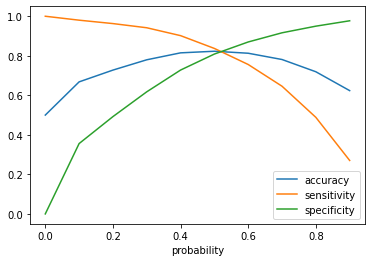

In [115]:
# Plotting accuracy, sensitivity and specificity for different probabilities.
cutoff_df.plot('probability', ['accuracy','sensitivity','specificity'])
plt.show()

At point 0.55 where the three parameters cut each other, we can see that there is a balance bethween sensitivity and specificity with a good accuracy.

In [116]:
# Creating a column with name "predicted", which is the predicted value for 0.5 cutoff 
y_train_pred_final['predicted'] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,churn,churn_prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,predicted
0,0,0.424375,0,1,1,1,1,1,0,0,0,0,0,0
1,0,0.004213,1,1,0,0,0,0,0,0,0,0,0,0
2,0,0.010114,2,1,0,0,0,0,0,0,0,0,0,0
3,0,0.547577,3,1,1,1,1,1,1,0,0,0,0,1
4,0,0.003573,4,1,0,0,0,0,0,0,0,0,0,0


In [117]:
# Confusion metrics
confusion = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['predicted'])
print(confusion)

[[17753  4198]
 [ 3576 18375]]


In [118]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [119]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_pred_final['churn'], y_train_pred_final['predicted']))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8229237847934034
Sensitivity:- 0.8370917042503758
Specificity:- 0.8087558653364312


In [120]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

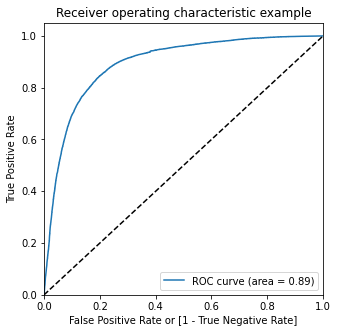

In [121]:
draw_roc(y_train_pred_final['churn'], y_train_pred_final['churn_prob'])

## Testing the model on the test set

In [122]:
# Taking a copy of the test set
X_test_log = X_test.copy()

In [123]:
# Taking only the columns, which are selected in the train set after removing insignificant and multicollinear variables
X_test_log = X_test_log[log_cols]

In [124]:
# Adding constant on the test set
X_test_sm = sm.add_constant(X_test_log)

In [125]:
# Predict on the test set
y_test_pred = log_no_pca_3.predict(X_test_sm)

In [126]:
y_test_pred.head()

76438    0.033865
72869    0.140363
86053    0.146881
29093    0.199625
96385    0.493541
dtype: float64

In [127]:
# Converting y_test_pred to a dataframe because y_test_pred is an array
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
76438,0.033865
72869,0.140363
86053,0.146881
29093,0.199625
96385,0.493541


In [128]:
# Converting y_test to a dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,churn
76438,0
72869,0
86053,0
29093,0
96385,0


In [129]:
# Putting index to Customer ID 
y_test_df['CustID'] = y_test_df.index

In [130]:
# Removing index form the both dataframes for merging them side by side
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [131]:
# Appending y_pred_1 and y_test_df
y_test_pred_final = pd.concat([y_test_df, y_pred_1], axis=1)

In [132]:
y_test_pred_final.head()

,churn,CustID,0
0,0,76438,0.033865
1,0,72869,0.140363
2,0,86053,0.146881
3,0,29093,0.199625
4,0,96385,0.493541


In [133]:
# Renaming the '0' column as churn probablity
y_test_pred_final = y_test_pred_final.rename(columns={0:'churn_prob'})

In [134]:

y_test_pred_final.head()

,churn,CustID,churn_prob
0,0,76438,0.033865
1,0,72869,0.140363
2,0,86053,0.146881
3,0,29093,0.199625
4,0,96385,0.493541


In [135]:
# In the test set using probablity cutoff 0.5, what we got in the train set 
y_test_pred_final['test_predicted'] = y_test_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

In [136]:
y_test_pred_final.head()

,churn,CustID,churn_prob,test_predicted
0,0,76438,0.033865,0
1,0,72869,0.140363,0
2,0,86053,0.146881,0
3,0,29093,0.199625,0
4,0,96385,0.493541,0


In [137]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test_pred_final['churn'], y_test_pred_final['test_predicted'])
print(confusion)

[[4404 1035]
 [ 155  402]]


In [138]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [139]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test_pred_final['churn'], y_test_pred_final['test_predicted']))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8015343562374917
Sensitivity:- 0.7217235188509874
Specificity:- 0.809707666850524


In [140]:
log_no_pca_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43902
Model:                            GLM   Df Residuals:                    43888
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18646.
Date:                Wed, 02 Mar 2022   Deviance:                       37292.
Time:                        20:49:34   Pearson chi2:                 1.47e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4154
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.2526      0.016    -15.965      0.000      -0.284      -0.222
arpu_7                       0.4503      0.018     25.482      0.000       0.416       0.485
loc_og_t2m_mou_6            -0.6121      0.016    -38.774      0.000      -0.643      -0.581
total_rech_num_7            -0.2432      0.015    -15.939      0.000      -0.273      -0.213
date_of_last_rech_8         -0.8388      0.016    -52.136      0.000      -0.870      -0.807
last_day_rch_amt_8          -0.9866      0.019    -50.980      0.000      -1.024      -0.949
monthly_2g_7                -0.6206      0.025    -24.583      0.000      -0.670      -0.571
monthly_2g_8                -0.8427      0.034    -24.687      0.000      -0.910      -0.776
sachet_2g_8                 -0.7799      0.023    -33.259      0.000      -0.826      -0.734
monthly_3g_7                -0.3873      0.022    -17.546      0.000      -0.431      -0.344
monthly_3g_8                -0.7694      0.031    -24.487      0.000      -0.831      -0.708
usage_median_int            -0.6491      0.019    -34.433      0.000      -0.686      -0.612
decrease_rech_num_action    -0.3285      0.015    -21.933      0.000      -0.358      -0.299
diff_mou                    -1.0372      0.020    -52.599      0.000      -1.076      -0.999
============================================================================================
"""

## Business Recomendation

From the above summary table we can say that top 10 feature are:


In [141]:
# Adding constant to X_train
X_train_sm_3 = sm.add_constant(X_train[log_cols])

#Instantiate the model
log_no_pca_3 = sm.GLM(y_train, X_train_sm_3, family=sm.families.Binomial())

# Fit the model
log_no_pca_3 = log_no_pca_3.fit()

log_no_pca_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43902
Model:                            GLM   Df Residuals:                    43888
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18646.
Date:                Wed, 02 Mar 2022   Deviance:                       37292.
Time:                        20:49:34   Pearson chi2:                 1.47e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4154
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.2526      0.016    -15.965      0.000      -0.284      -0.222
arpu_7                       0.4503      0.018     25.482      0.000       0.416       0.485
loc_og_t2m_mou_6            -0.6121      0.016    -38.774      0.000      -0.643      -0.581
total_rech_num_7            -0.2432      0.015    -15.939      0.000      -0.273      -0.213
date_of_last_rech_8         -0.8388      0.016    -52.136      0.000      -0.870      -0.807
last_day_rch_amt_8          -0.9866      0.019    -50.980      0.000      -1.024      -0.949
monthly_2g_7                -0.6206      0.025    -24.583      0.000      -0.670      -0.571
monthly_2g_8                -0.8427      0.034    -24.687      0.000      -0.910      -0.776
sachet_2g_8                 -0.7799      0.023    -33.259      0.000      -0.826      -0.734
monthly_3g_7                -0.3873      0.022    -17.546      0.000      -0.431      -0.344
monthly_3g_8                -0.7694      0.031    -24.487      0.000      -0.831      -0.708
usage_median_int            -0.6491      0.019    -34.433      0.000      -0.686      -0.612
decrease_rech_num_action    -0.3285      0.015    -21.933      0.000      -0.358      -0.299
diff_mou                    -1.0372      0.020    -52.599      0.000      -1.076      -0.999
============================================================================================
"""

In [142]:
logR = LogisticRegression()
final_logR = logR.fit(X_train[log_cols],y_train)

In [143]:
cols = X_train[log_cols].columns
cols

Index(['arpu_7', 'loc_og_t2m_mou_6', 'total_rech_num_7', 'date_of_last_rech_8',
       'last_day_rch_amt_8', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_7', 'monthly_3g_8', 'usage_median_int',
       'decrease_rech_num_action', 'diff_mou'],
      dtype='object')

In [144]:
LogR_coef = pd.DataFrame(list(zip(cols,final_logR.coef_.tolist()[0])))
LogR_coef.columns = ['Feaure','Coef']
LogR_coef.sort_values(by='Coef',ascending=False).head(15)

,Feaure,Coef
0,arpu_7,0.449895
2,total_rech_num_7,-0.242931
11,decrease_rech_num_action,-0.328208
8,monthly_3g_7,-0.386909
1,loc_og_t2m_mou_6,-0.611757
5,monthly_2g_7,-0.620147
10,usage_median_int,-0.648326
9,monthly_3g_8,-0.768638
7,sachet_2g_8,-0.779187
3,date_of_last_rech_8,-0.838415


In [145]:
LogR_coef['Abs_Coef'] = abs(LogR_coef['Coef'])

## Top 10 predictors are:
- diff_mou
- last_day_rch_amt_8
- monthly_2g_8
- date_of_last_rech_8
- sachet_2g_8
- monthly_3g_8
- usage_median_int
- monthly_2g_7
- loc_og_t2m_mou_6
- arpu_7
- monthly_3g_7
- decrease_rech_num_action
- total_rech_num_7

In [146]:
LogR_coef.sort_values(by='Abs_Coef',ascending=False).head(15)

,Feaure,Coef,Abs_Coef
12,diff_mou,-1.036619,1.036619
4,last_day_rch_amt_8,-0.986050,0.986050
6,monthly_2g_8,-0.841510,0.841510
3,date_of_last_rech_8,-0.838415,0.838415
7,sachet_2g_8,-0.779187,0.779187
9,monthly_3g_8,-0.768638,0.768638
10,usage_median_int,-0.648326,0.648326
5,monthly_2g_7,-0.620147,0.620147
1,loc_og_t2m_mou_6,-0.611757,0.611757
0,arpu_7,0.449895,0.449895


We can see most of the top variables have negative coefficients. That means, the variables are inversely correlated with the churn probablity.

## Recommendations:

- Target the customers whose difference in minute of usage is decreasing in action and good phase
- Target the customer whose last recharge in august, monthly 3g and monthly 2g in august are less
- Target the customer whose local to other opretaor voice call and minute of usage is less


In [150]:
# Creating churn dataframe
data_churn = telecom_preped_data[telecom_preped_data['churn'] == 1]
# Creating not churn dataframe
data_non_churn = telecom_preped_data[telecom_preped_data['churn'] == 0]

In [153]:
data_non_churn.columns

Index(['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'offnet_mou_6', 'offnet_mou_7', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6',
       'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_t2c_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'isd_og_mou_6', 'spl_og_mou_6', 'spl_og_mou_7',
       'spl_og_mou_8', 'og_others_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6',
       'loc_ic_t2f_mou_6', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7',
       'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7',
       'std_ic_t2f_mou_8', 'isd_ic_mou_6', 'ic_others_6', 'ic_others_7',
       'ic_others_8', 'total_rech_num_6', 'total_rech_num_7', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'date_of_last_rech_6',
       'date_of_last_rech_7', 'date_of_last_rech_8', 'last_day_rch_amt_6',
       'last_day_rch_amt_7', 'last_day_rch_amt_8', 'monthly_2g_6',
       'mont

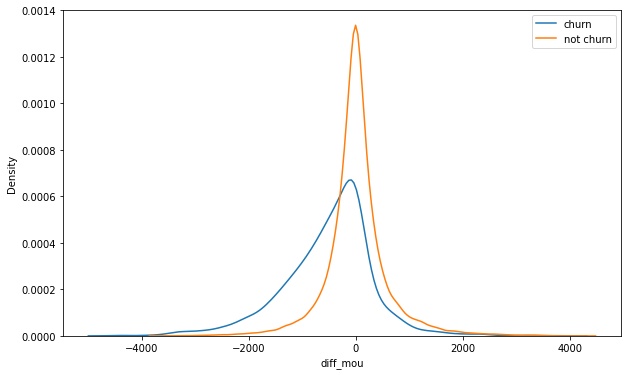

In [164]:
# Plotting diff_mou predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['diff_mou'],label='churn',hist=False)
sns.distplot(data_non_churn['diff_mou'],label='not churn',hist=False)
plt.legend()
plt.show()

We can see that difference in minutes of usage is less for churn user

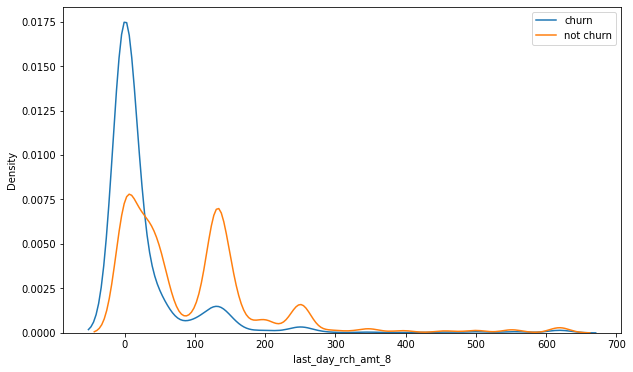

In [163]:
# Plotting last_day_rch_amt_8 predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['last_day_rch_amt_8'],label='churn',hist=False)
sns.distplot(data_non_churn['last_day_rch_amt_8'],label='not churn',hist=False)
plt.legend()
plt.show()

Similarly the last_day recharge amount for churn user is concenterated toward zero

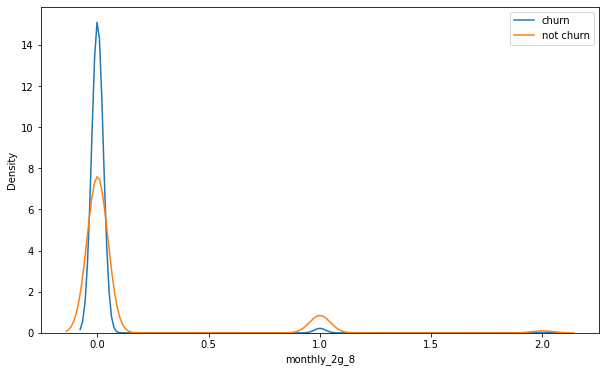

In [162]:
# Plotting monthly_2g_8 predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['monthly_2g_8'],label='churn',hist=False)
sns.distplot(data_non_churn['monthly_2g_8'],label='not churn',hist=False)
plt.legend()
plt.show()


And the last month 2g usage is also concenterated on zero for churn user